In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

In [17]:
data_dir= '../../data/mechanical_loading_datasets/'
file = '500mAh3.xlsx'

data = pd.read_excel(data_dir+file, sheet_name= 'temperature',header=[0,1])

print(data.shape, data.columns)

(13380, 10) MultiIndex([(0.2,        'time/s'),
            (0.2, 'temperature/℃'),
            (0.4,        'time/s'),
            (0.4, 'temperature/℃'),
            (0.6,        'time/s'),
            (0.6, 'temperature/℃'),
            (0.8,        'time/s'),
            (0.8, 'temperature/℃'),
            (1.0,        'time/s'),
            (1.0, 'temperature/℃')],
           )


Text(0, 0.5, 'temperature')

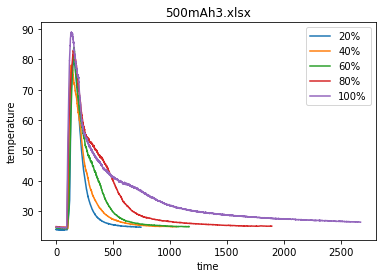

In [18]:
plt.plot(data[(0.2, 'time/s')], data[(0.2, 'temperature/℃')], label='20%')
plt.plot(data[(0.4, 'time/s')], data[(0.4, 'temperature/℃')], label='40%')
plt.plot(data[(0.6, 'time/s')], data[(0.6, 'temperature/℃')], label='60%')
plt.plot(data[(0.8, 'time/s')], data[(0.8, 'temperature/℃')], label='80%')
plt.plot(data[(1.0, 'time/s')], data[(1.0, 'temperature/℃')], label='100%')
plt.title(file)
plt.legend()
plt.xlabel('time')
plt.ylabel('temperature')

# loss analysis

Text(0.5, 1.0, 'nbeats-epochs-100')

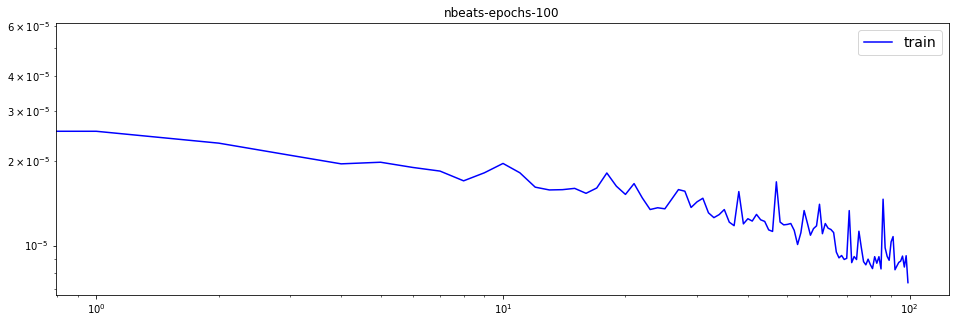

In [7]:
file = '../results/loss.txt'
floss = pd.read_csv(file, delimiter=',')

fig,axs=plt.subplots(1,1,figsize=(16,5))
#ax=axs[0]
axs.loglog(floss['loss'].values.ravel(),c='b')
#ax.loglog(floss['val_loss'].values.ravel(),c='g')
axs.legend(['train'],fontsize=14)
axs.set_title("nbeats-epochs-100")


# forecast plot

In [2]:
from torch.utils.data import DataLoader

In [3]:
class DataSampler:
    def __init__(self, data_dir, in_size, time_lag, out_size, is_test, test_data=None):
        super().__init__()
        ids=[]
        self.labels=[0.2, 0.4, 0.6, 0.8, 1.0]
        self.insample_size = in_size
        self.time_lag = time_lag
        self.horizon = out_size
        self.ts_len = in_size+time_lag+out_size
        self.cutpoints=[]
        #self.forecast_sidx=[]
        self.ts_index=[]
        self.timeseries=[]
        num_ts=0
        if is_test:
           data = pd.read_excel(data_dir+test_data, engine='openpyxl', 
                                sheet_name= 'temperature', 
                                header=[0,1])
           ts = data[(1.0, 'temperature/℃')].to_numpy()
           ts = ts[~np.isnan(ts)]
           
           self.timeseries.append(ts)
           forecast_sidx = len(ts)-self.horizon
           cp = np.arange(self.insample_size, forecast_sidx-self.time_lag,1, dtype= int)
           total_cp = len(cp) 
           self.ts_index+= [num_ts]*total_cp
           self.cutpoints+=list(cp)
                     
        else:
            fids=os.listdir(data_dir)
        
            for file in fids:
                if file[-4:]!='xlsx':
                    continue
                ids.append(file)
        
            for fid in ids:
                data = pd.read_excel(data_dir+file, engine='openpyxl', 
                                     sheet_name= 'temperature', header=[0,1])
                for l in self.labels:
                    if fid==test_data and l==1.0:
                        continue
                    ts = data[(l, 'temperature/℃')].to_numpy()
                    ts = ts[~np.isnan(ts)]
                    self.timeseries.append(ts)
                    
                    forecast_sidx = len(ts)-self.horizon
                    cp = np.arange(self.insample_size, forecast_sidx-self.time_lag, 1, 
                                   dtype= int)
                    total_cp = len(cp) 
                    self.ts_index+= [num_ts]*total_cp
                    self.cutpoints+=list(cp)
                    num_ts+=1
        
        print(len(self.cutpoints),len(self.ts_index))

    def __len__(self): 
        return len(self.cutpoints)
    
    def __getitem__(self,i):
        
        start_id = self.cutpoints[i]-self.insample_size
        sid_y = self.cutpoints[i]+self.time_lag
        eid = sid_y+self.horizon
        ts = self.timeseries[self.ts_index[i]]
         
        X= ts[start_id:self.cutpoints[i]]
        y = ts[sid_y:eid]
        
        return torch.tensor(X), torch.tensor(y), self.cutpoints[i], sid_y, eid


In [4]:
dir_data = '../../data/mechanical_loading_datasets/'
history_size = 50
time_lag = 50
horizon = 10
test_data = '500mAh3.xlsx'
data=DataSampler(dir_data, history_size, time_lag, horizon, is_test=True, 
                test_data=test_data)

data_loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=True)

13270 13270


In [18]:
out_dir = '../results/forecast_test_seasonal.csv' 
data = pd.read_excel(dir_data+test_data, engine='openpyxl', sheet_name= 'temperature', 
                    header=[0,1])
ts = data[(1.0, 'temperature/℃')].to_numpy()
ts = ts[~np.isnan(ts)]

forecast = pd.read_csv(out_dir,delimiter=',',index_col='id', header =0) 
print(forecast.shape, ts.shape)


(13270, 10) (13380,)


In [19]:
global_forecast = np.zeros(len(ts))
global_count = np.zeros(len(ts))

In [20]:
for idx, (X, y,cps,fsid,feid) in enumerate(data_loader):
    X = X.numpy()
    y = y.numpy()
    cps =cps.item()
    o_sid = cps-history_size
    o_eid = cps+time_lag+horizon
    fsid =fsid.item()
    feid = feid.item()
    
    pred_ts = forecast.loc[[idx]]
    pred_ts = pred_ts.to_numpy()
    
    predix=0
    print(idx,o_sid,o_eid,fsid,feid)
    for fidx in range(fsid,feid):
        global_forecast[fidx]+=pred_ts[0,predix]
        global_count[fidx]+=1
        predix+=1
    
    
    pltx = np.arange(o_sid,o_eid+1)
    #orig_ts = np.concatenate(X,y,axis=1)
    orig_ts = ts[o_sid:o_eid+1]
    #print(X.shape,y.shape,orig_ts.shape,cps,fsid,feid)
    
    print(o_sid,o_eid,cps,fsid,feid,len(pltx),len(pltx[fsid:feid]),len(pred_ts[0]))
    
    '''
    plt.plot(pltx,ts[o_sid:o_eid+1],linewidth = 2, color='k')
    
    plt.plot(pltx[fsid:feid],pred_ts[0],linewidth =2, color = 'r')
    
    plt.axvline(x=cps, linewidth = 1, color='g' )
    plt.axvline(x=cps+time_lag, linewidth =1, color = 'g')
    title = test_data+':'+str(o_sid)+'-'+str(feid)
    plt.title(title)
    plt.show()
    '''
for id in range(len(global_forecast)):
    if global_count[id]!=0:
        global_forecast[id]/=global_count[id]

#show a global view instead local

0 0 110 100 110
0 110 50 100 110 111 10 10
1 1 111 101 111
1 111 51 101 111 111 10 10
2 2 112 102 112
2 112 52 102 112 111 9 10
3 3 113 103 113
3 113 53 103 113 111 8 10
4 4 114 104 114
4 114 54 104 114 111 7 10
5 5 115 105 115
5 115 55 105 115 111 6 10
6 6 116 106 116
6 116 56 106 116 111 5 10
7 7 117 107 117
7 117 57 107 117 111 4 10
8 8 118 108 118
8 118 58 108 118 111 3 10
9 9 119 109 119
9 119 59 109 119 111 2 10
10 10 120 110 120
10 120 60 110 120 111 1 10
11 11 121 111 121
11 121 61 111 121 111 0 10
12 12 122 112 122
12 122 62 112 122 111 0 10
13 13 123 113 123
13 123 63 113 123 111 0 10
14 14 124 114 124
14 124 64 114 124 111 0 10
15 15 125 115 125
15 125 65 115 125 111 0 10
16 16 126 116 126
16 126 66 116 126 111 0 10
17 17 127 117 127
17 127 67 117 127 111 0 10
18 18 128 118 128
18 128 68 118 128 111 0 10
19 19 129 119 129
19 129 69 119 129 111 0 10
20 20 130 120 130
20 130 70 120 130 111 0 10
21 21 131 121 131
21 131 71 121 131 111 0 10
22 22 132 122 132
22 132 72 122 132 11

223 223 333 323 333
223 333 273 323 333 111 0 10
224 224 334 324 334
224 334 274 324 334 111 0 10
225 225 335 325 335
225 335 275 325 335 111 0 10
226 226 336 326 336
226 336 276 326 336 111 0 10
227 227 337 327 337
227 337 277 327 337 111 0 10
228 228 338 328 338
228 338 278 328 338 111 0 10
229 229 339 329 339
229 339 279 329 339 111 0 10
230 230 340 330 340
230 340 280 330 340 111 0 10
231 231 341 331 341
231 341 281 331 341 111 0 10
232 232 342 332 342
232 342 282 332 342 111 0 10
233 233 343 333 343
233 343 283 333 343 111 0 10
234 234 344 334 344
234 344 284 334 344 111 0 10
235 235 345 335 345
235 345 285 335 345 111 0 10
236 236 346 336 346
236 346 286 336 346 111 0 10
237 237 347 337 347
237 347 287 337 347 111 0 10
238 238 348 338 348
238 348 288 338 348 111 0 10
239 239 349 339 349
239 349 289 339 349 111 0 10
240 240 350 340 350
240 350 290 340 350 111 0 10
241 241 351 341 351
241 351 291 341 351 111 0 10
242 242 352 342 352
242 352 292 342 352 111 0 10
243 243 353 343 353


407 407 517 507 517
407 517 457 507 517 111 0 10
408 408 518 508 518
408 518 458 508 518 111 0 10
409 409 519 509 519
409 519 459 509 519 111 0 10
410 410 520 510 520
410 520 460 510 520 111 0 10
411 411 521 511 521
411 521 461 511 521 111 0 10
412 412 522 512 522
412 522 462 512 522 111 0 10
413 413 523 513 523
413 523 463 513 523 111 0 10
414 414 524 514 524
414 524 464 514 524 111 0 10
415 415 525 515 525
415 525 465 515 525 111 0 10
416 416 526 516 526
416 526 466 516 526 111 0 10
417 417 527 517 527
417 527 467 517 527 111 0 10
418 418 528 518 528
418 528 468 518 528 111 0 10
419 419 529 519 529
419 529 469 519 529 111 0 10
420 420 530 520 530
420 530 470 520 530 111 0 10
421 421 531 521 531
421 531 471 521 531 111 0 10
422 422 532 522 532
422 532 472 522 532 111 0 10
423 423 533 523 533
423 533 473 523 533 111 0 10
424 424 534 524 534
424 534 474 524 534 111 0 10
425 425 535 525 535
425 535 475 525 535 111 0 10
426 426 536 526 536
426 536 476 526 536 111 0 10
427 427 537 527 537


593 593 703 693 703
593 703 643 693 703 111 0 10
594 594 704 694 704
594 704 644 694 704 111 0 10
595 595 705 695 705
595 705 645 695 705 111 0 10
596 596 706 696 706
596 706 646 696 706 111 0 10
597 597 707 697 707
597 707 647 697 707 111 0 10
598 598 708 698 708
598 708 648 698 708 111 0 10
599 599 709 699 709
599 709 649 699 709 111 0 10
600 600 710 700 710
600 710 650 700 710 111 0 10
601 601 711 701 711
601 711 651 701 711 111 0 10
602 602 712 702 712
602 712 652 702 712 111 0 10
603 603 713 703 713
603 713 653 703 713 111 0 10
604 604 714 704 714
604 714 654 704 714 111 0 10
605 605 715 705 715
605 715 655 705 715 111 0 10
606 606 716 706 716
606 716 656 706 716 111 0 10
607 607 717 707 717
607 717 657 707 717 111 0 10
608 608 718 708 718
608 718 658 708 718 111 0 10
609 609 719 709 719
609 719 659 709 719 111 0 10
610 610 720 710 720
610 720 660 710 720 111 0 10
611 611 721 711 721
611 721 661 711 721 111 0 10
612 612 722 712 722
612 722 662 712 722 111 0 10
613 613 723 713 723


772 772 882 872 882
772 882 822 872 882 111 0 10
773 773 883 873 883
773 883 823 873 883 111 0 10
774 774 884 874 884
774 884 824 874 884 111 0 10
775 775 885 875 885
775 885 825 875 885 111 0 10
776 776 886 876 886
776 886 826 876 886 111 0 10
777 777 887 877 887
777 887 827 877 887 111 0 10
778 778 888 878 888
778 888 828 878 888 111 0 10
779 779 889 879 889
779 889 829 879 889 111 0 10
780 780 890 880 890
780 890 830 880 890 111 0 10
781 781 891 881 891
781 891 831 881 891 111 0 10
782 782 892 882 892
782 892 832 882 892 111 0 10
783 783 893 883 893
783 893 833 883 893 111 0 10
784 784 894 884 894
784 894 834 884 894 111 0 10
785 785 895 885 895
785 895 835 885 895 111 0 10
786 786 896 886 896
786 896 836 886 896 111 0 10
787 787 897 887 897
787 897 837 887 897 111 0 10
788 788 898 888 898
788 898 838 888 898 111 0 10
789 789 899 889 899
789 899 839 889 899 111 0 10
790 790 900 890 900
790 900 840 890 900 111 0 10
791 791 901 891 901
791 901 841 891 901 111 0 10
792 792 902 892 902


993 993 1103 1093 1103
993 1103 1043 1093 1103 111 0 10
994 994 1104 1094 1104
994 1104 1044 1094 1104 111 0 10
995 995 1105 1095 1105
995 1105 1045 1095 1105 111 0 10
996 996 1106 1096 1106
996 1106 1046 1096 1106 111 0 10
997 997 1107 1097 1107
997 1107 1047 1097 1107 111 0 10
998 998 1108 1098 1108
998 1108 1048 1098 1108 111 0 10
999 999 1109 1099 1109
999 1109 1049 1099 1109 111 0 10
1000 1000 1110 1100 1110
1000 1110 1050 1100 1110 111 0 10
1001 1001 1111 1101 1111
1001 1111 1051 1101 1111 111 0 10
1002 1002 1112 1102 1112
1002 1112 1052 1102 1112 111 0 10
1003 1003 1113 1103 1113
1003 1113 1053 1103 1113 111 0 10
1004 1004 1114 1104 1114
1004 1114 1054 1104 1114 111 0 10
1005 1005 1115 1105 1115
1005 1115 1055 1105 1115 111 0 10
1006 1006 1116 1106 1116
1006 1116 1056 1106 1116 111 0 10
1007 1007 1117 1107 1117
1007 1117 1057 1107 1117 111 0 10
1008 1008 1118 1108 1118
1008 1118 1058 1108 1118 111 0 10
1009 1009 1119 1109 1119
1009 1119 1059 1109 1119 111 0 10
1010 1010 1120 111

1185 1185 1295 1285 1295
1185 1295 1235 1285 1295 111 0 10
1186 1186 1296 1286 1296
1186 1296 1236 1286 1296 111 0 10
1187 1187 1297 1287 1297
1187 1297 1237 1287 1297 111 0 10
1188 1188 1298 1288 1298
1188 1298 1238 1288 1298 111 0 10
1189 1189 1299 1289 1299
1189 1299 1239 1289 1299 111 0 10
1190 1190 1300 1290 1300
1190 1300 1240 1290 1300 111 0 10
1191 1191 1301 1291 1301
1191 1301 1241 1291 1301 111 0 10
1192 1192 1302 1292 1302
1192 1302 1242 1292 1302 111 0 10
1193 1193 1303 1293 1303
1193 1303 1243 1293 1303 111 0 10
1194 1194 1304 1294 1304
1194 1304 1244 1294 1304 111 0 10
1195 1195 1305 1295 1305
1195 1305 1245 1295 1305 111 0 10
1196 1196 1306 1296 1306
1196 1306 1246 1296 1306 111 0 10
1197 1197 1307 1297 1307
1197 1307 1247 1297 1307 111 0 10
1198 1198 1308 1298 1308
1198 1308 1248 1298 1308 111 0 10
1199 1199 1309 1299 1309
1199 1309 1249 1299 1309 111 0 10
1200 1200 1310 1300 1310
1200 1310 1250 1300 1310 111 0 10
1201 1201 1311 1301 1311
1201 1311 1251 1301 1311 111 0 

1377 1487 1427 1477 1487 111 0 10
1378 1378 1488 1478 1488
1378 1488 1428 1478 1488 111 0 10
1379 1379 1489 1479 1489
1379 1489 1429 1479 1489 111 0 10
1380 1380 1490 1480 1490
1380 1490 1430 1480 1490 111 0 10
1381 1381 1491 1481 1491
1381 1491 1431 1481 1491 111 0 10
1382 1382 1492 1482 1492
1382 1492 1432 1482 1492 111 0 10
1383 1383 1493 1483 1493
1383 1493 1433 1483 1493 111 0 10
1384 1384 1494 1484 1494
1384 1494 1434 1484 1494 111 0 10
1385 1385 1495 1485 1495
1385 1495 1435 1485 1495 111 0 10
1386 1386 1496 1486 1496
1386 1496 1436 1486 1496 111 0 10
1387 1387 1497 1487 1497
1387 1497 1437 1487 1497 111 0 10
1388 1388 1498 1488 1498
1388 1498 1438 1488 1498 111 0 10
1389 1389 1499 1489 1499
1389 1499 1439 1489 1499 111 0 10
1390 1390 1500 1490 1500
1390 1500 1440 1490 1500 111 0 10
1391 1391 1501 1491 1501
1391 1501 1441 1491 1501 111 0 10
1392 1392 1502 1492 1502
1392 1502 1442 1492 1502 111 0 10
1393 1393 1503 1493 1503
1393 1503 1443 1493 1503 111 0 10
1394 1394 1504 1494 15

1568 1568 1678 1668 1678
1568 1678 1618 1668 1678 111 0 10
1569 1569 1679 1669 1679
1569 1679 1619 1669 1679 111 0 10
1570 1570 1680 1670 1680
1570 1680 1620 1670 1680 111 0 10
1571 1571 1681 1671 1681
1571 1681 1621 1671 1681 111 0 10
1572 1572 1682 1672 1682
1572 1682 1622 1672 1682 111 0 10
1573 1573 1683 1673 1683
1573 1683 1623 1673 1683 111 0 10
1574 1574 1684 1674 1684
1574 1684 1624 1674 1684 111 0 10
1575 1575 1685 1675 1685
1575 1685 1625 1675 1685 111 0 10
1576 1576 1686 1676 1686
1576 1686 1626 1676 1686 111 0 10
1577 1577 1687 1677 1687
1577 1687 1627 1677 1687 111 0 10
1578 1578 1688 1678 1688
1578 1688 1628 1678 1688 111 0 10
1579 1579 1689 1679 1689
1579 1689 1629 1679 1689 111 0 10
1580 1580 1690 1680 1690
1580 1690 1630 1680 1690 111 0 10
1581 1581 1691 1681 1691
1581 1691 1631 1681 1691 111 0 10
1582 1582 1692 1682 1692
1582 1692 1632 1682 1692 111 0 10
1583 1583 1693 1683 1693
1583 1693 1633 1683 1693 111 0 10
1584 1584 1694 1684 1694
1584 1694 1634 1684 1694 111 0 

1760 1760 1870 1860 1870
1760 1870 1810 1860 1870 111 0 10
1761 1761 1871 1861 1871
1761 1871 1811 1861 1871 111 0 10
1762 1762 1872 1862 1872
1762 1872 1812 1862 1872 111 0 10
1763 1763 1873 1863 1873
1763 1873 1813 1863 1873 111 0 10
1764 1764 1874 1864 1874
1764 1874 1814 1864 1874 111 0 10
1765 1765 1875 1865 1875
1765 1875 1815 1865 1875 111 0 10
1766 1766 1876 1866 1876
1766 1876 1816 1866 1876 111 0 10
1767 1767 1877 1867 1877
1767 1877 1817 1867 1877 111 0 10
1768 1768 1878 1868 1878
1768 1878 1818 1868 1878 111 0 10
1769 1769 1879 1869 1879
1769 1879 1819 1869 1879 111 0 10
1770 1770 1880 1870 1880
1770 1880 1820 1870 1880 111 0 10
1771 1771 1881 1871 1881
1771 1881 1821 1871 1881 111 0 10
1772 1772 1882 1872 1882
1772 1882 1822 1872 1882 111 0 10
1773 1773 1883 1873 1883
1773 1883 1823 1873 1883 111 0 10
1774 1774 1884 1874 1884
1774 1884 1824 1874 1884 111 0 10
1775 1775 1885 1875 1885
1775 1885 1825 1875 1885 111 0 10
1776 1776 1886 1876 1886
1776 1886 1826 1876 1886 111 0 

1954 1954 2064 2054 2064
1954 2064 2004 2054 2064 111 0 10
1955 1955 2065 2055 2065
1955 2065 2005 2055 2065 111 0 10
1956 1956 2066 2056 2066
1956 2066 2006 2056 2066 111 0 10
1957 1957 2067 2057 2067
1957 2067 2007 2057 2067 111 0 10
1958 1958 2068 2058 2068
1958 2068 2008 2058 2068 111 0 10
1959 1959 2069 2059 2069
1959 2069 2009 2059 2069 111 0 10
1960 1960 2070 2060 2070
1960 2070 2010 2060 2070 111 0 10
1961 1961 2071 2061 2071
1961 2071 2011 2061 2071 111 0 10
1962 1962 2072 2062 2072
1962 2072 2012 2062 2072 111 0 10
1963 1963 2073 2063 2073
1963 2073 2013 2063 2073 111 0 10
1964 1964 2074 2064 2074
1964 2074 2014 2064 2074 111 0 10
1965 1965 2075 2065 2075
1965 2075 2015 2065 2075 111 0 10
1966 1966 2076 2066 2076
1966 2076 2016 2066 2076 111 0 10
1967 1967 2077 2067 2077
1967 2077 2017 2067 2077 111 0 10
1968 1968 2078 2068 2078
1968 2078 2018 2068 2078 111 0 10
1969 1969 2079 2069 2079
1969 2079 2019 2069 2079 111 0 10
1970 1970 2080 2070 2080
1970 2080 2020 2070 2080 111 0 

2157 2267 2207 2257 2267 111 0 10
2158 2158 2268 2258 2268
2158 2268 2208 2258 2268 111 0 10
2159 2159 2269 2259 2269
2159 2269 2209 2259 2269 111 0 10
2160 2160 2270 2260 2270
2160 2270 2210 2260 2270 111 0 10
2161 2161 2271 2261 2271
2161 2271 2211 2261 2271 111 0 10
2162 2162 2272 2262 2272
2162 2272 2212 2262 2272 111 0 10
2163 2163 2273 2263 2273
2163 2273 2213 2263 2273 111 0 10
2164 2164 2274 2264 2274
2164 2274 2214 2264 2274 111 0 10
2165 2165 2275 2265 2275
2165 2275 2215 2265 2275 111 0 10
2166 2166 2276 2266 2276
2166 2276 2216 2266 2276 111 0 10
2167 2167 2277 2267 2277
2167 2277 2217 2267 2277 111 0 10
2168 2168 2278 2268 2278
2168 2278 2218 2268 2278 111 0 10
2169 2169 2279 2269 2279
2169 2279 2219 2269 2279 111 0 10
2170 2170 2280 2270 2280
2170 2280 2220 2270 2280 111 0 10
2171 2171 2281 2271 2281
2171 2281 2221 2271 2281 111 0 10
2172 2172 2282 2272 2282
2172 2282 2222 2272 2282 111 0 10
2173 2173 2283 2273 2283
2173 2283 2223 2273 2283 111 0 10
2174 2174 2284 2274 22

2369 2369 2479 2469 2479
2369 2479 2419 2469 2479 111 0 10
2370 2370 2480 2470 2480
2370 2480 2420 2470 2480 111 0 10
2371 2371 2481 2471 2481
2371 2481 2421 2471 2481 111 0 10
2372 2372 2482 2472 2482
2372 2482 2422 2472 2482 111 0 10
2373 2373 2483 2473 2483
2373 2483 2423 2473 2483 111 0 10
2374 2374 2484 2474 2484
2374 2484 2424 2474 2484 111 0 10
2375 2375 2485 2475 2485
2375 2485 2425 2475 2485 111 0 10
2376 2376 2486 2476 2486
2376 2486 2426 2476 2486 111 0 10
2377 2377 2487 2477 2487
2377 2487 2427 2477 2487 111 0 10
2378 2378 2488 2478 2488
2378 2488 2428 2478 2488 111 0 10
2379 2379 2489 2479 2489
2379 2489 2429 2479 2489 111 0 10
2380 2380 2490 2480 2490
2380 2490 2430 2480 2490 111 0 10
2381 2381 2491 2481 2491
2381 2491 2431 2481 2491 111 0 10
2382 2382 2492 2482 2492
2382 2492 2432 2482 2492 111 0 10
2383 2383 2493 2483 2493
2383 2493 2433 2483 2493 111 0 10
2384 2384 2494 2484 2494
2384 2494 2434 2484 2494 111 0 10
2385 2385 2495 2485 2495
2385 2495 2435 2485 2495 111 0 

2562 2562 2672 2662 2672
2562 2672 2612 2662 2672 111 0 10
2563 2563 2673 2663 2673
2563 2673 2613 2663 2673 111 0 10
2564 2564 2674 2664 2674
2564 2674 2614 2664 2674 111 0 10
2565 2565 2675 2665 2675
2565 2675 2615 2665 2675 111 0 10
2566 2566 2676 2666 2676
2566 2676 2616 2666 2676 111 0 10
2567 2567 2677 2667 2677
2567 2677 2617 2667 2677 111 0 10
2568 2568 2678 2668 2678
2568 2678 2618 2668 2678 111 0 10
2569 2569 2679 2669 2679
2569 2679 2619 2669 2679 111 0 10
2570 2570 2680 2670 2680
2570 2680 2620 2670 2680 111 0 10
2571 2571 2681 2671 2681
2571 2681 2621 2671 2681 111 0 10
2572 2572 2682 2672 2682
2572 2682 2622 2672 2682 111 0 10
2573 2573 2683 2673 2683
2573 2683 2623 2673 2683 111 0 10
2574 2574 2684 2674 2684
2574 2684 2624 2674 2684 111 0 10
2575 2575 2685 2675 2685
2575 2685 2625 2675 2685 111 0 10
2576 2576 2686 2676 2686
2576 2686 2626 2676 2686 111 0 10
2577 2577 2687 2677 2687
2577 2687 2627 2677 2687 111 0 10
2578 2578 2688 2678 2688
2578 2688 2628 2678 2688 111 0 

2800 2800 2910 2900 2910
2800 2910 2850 2900 2910 111 0 10
2801 2801 2911 2901 2911
2801 2911 2851 2901 2911 111 0 10
2802 2802 2912 2902 2912
2802 2912 2852 2902 2912 111 0 10
2803 2803 2913 2903 2913
2803 2913 2853 2903 2913 111 0 10
2804 2804 2914 2904 2914
2804 2914 2854 2904 2914 111 0 10
2805 2805 2915 2905 2915
2805 2915 2855 2905 2915 111 0 10
2806 2806 2916 2906 2916
2806 2916 2856 2906 2916 111 0 10
2807 2807 2917 2907 2917
2807 2917 2857 2907 2917 111 0 10
2808 2808 2918 2908 2918
2808 2918 2858 2908 2918 111 0 10
2809 2809 2919 2909 2919
2809 2919 2859 2909 2919 111 0 10
2810 2810 2920 2910 2920
2810 2920 2860 2910 2920 111 0 10
2811 2811 2921 2911 2921
2811 2921 2861 2911 2921 111 0 10
2812 2812 2922 2912 2922
2812 2922 2862 2912 2922 111 0 10
2813 2813 2923 2913 2923
2813 2923 2863 2913 2923 111 0 10
2814 2814 2924 2914 2924
2814 2924 2864 2914 2924 111 0 10
2815 2815 2925 2915 2925
2815 2925 2865 2915 2925 111 0 10
2816 2816 2926 2916 2926
2816 2926 2866 2916 2926 111 0 

2992 2992 3102 3092 3102
2992 3102 3042 3092 3102 111 0 10
2993 2993 3103 3093 3103
2993 3103 3043 3093 3103 111 0 10
2994 2994 3104 3094 3104
2994 3104 3044 3094 3104 111 0 10
2995 2995 3105 3095 3105
2995 3105 3045 3095 3105 111 0 10
2996 2996 3106 3096 3106
2996 3106 3046 3096 3106 111 0 10
2997 2997 3107 3097 3107
2997 3107 3047 3097 3107 111 0 10
2998 2998 3108 3098 3108
2998 3108 3048 3098 3108 111 0 10
2999 2999 3109 3099 3109
2999 3109 3049 3099 3109 111 0 10
3000 3000 3110 3100 3110
3000 3110 3050 3100 3110 111 0 10
3001 3001 3111 3101 3111
3001 3111 3051 3101 3111 111 0 10
3002 3002 3112 3102 3112
3002 3112 3052 3102 3112 111 0 10
3003 3003 3113 3103 3113
3003 3113 3053 3103 3113 111 0 10
3004 3004 3114 3104 3114
3004 3114 3054 3104 3114 111 0 10
3005 3005 3115 3105 3115
3005 3115 3055 3105 3115 111 0 10
3006 3006 3116 3106 3116
3006 3116 3056 3106 3116 111 0 10
3007 3007 3117 3107 3117
3007 3117 3057 3107 3117 111 0 10
3008 3008 3118 3108 3118
3008 3118 3058 3108 3118 111 0 

3184 3294 3234 3284 3294 111 0 10
3185 3185 3295 3285 3295
3185 3295 3235 3285 3295 111 0 10
3186 3186 3296 3286 3296
3186 3296 3236 3286 3296 111 0 10
3187 3187 3297 3287 3297
3187 3297 3237 3287 3297 111 0 10
3188 3188 3298 3288 3298
3188 3298 3238 3288 3298 111 0 10
3189 3189 3299 3289 3299
3189 3299 3239 3289 3299 111 0 10
3190 3190 3300 3290 3300
3190 3300 3240 3290 3300 111 0 10
3191 3191 3301 3291 3301
3191 3301 3241 3291 3301 111 0 10
3192 3192 3302 3292 3302
3192 3302 3242 3292 3302 111 0 10
3193 3193 3303 3293 3303
3193 3303 3243 3293 3303 111 0 10
3194 3194 3304 3294 3304
3194 3304 3244 3294 3304 111 0 10
3195 3195 3305 3295 3305
3195 3305 3245 3295 3305 111 0 10
3196 3196 3306 3296 3306
3196 3306 3246 3296 3306 111 0 10
3197 3197 3307 3297 3307
3197 3307 3247 3297 3307 111 0 10
3198 3198 3308 3298 3308
3198 3308 3248 3298 3308 111 0 10
3199 3199 3309 3299 3309
3199 3309 3249 3299 3309 111 0 10
3200 3200 3310 3300 3310
3200 3310 3250 3300 3310 111 0 10
3201 3201 3311 3301 33

3385 3385 3495 3485 3495
3385 3495 3435 3485 3495 111 0 10
3386 3386 3496 3486 3496
3386 3496 3436 3486 3496 111 0 10
3387 3387 3497 3487 3497
3387 3497 3437 3487 3497 111 0 10
3388 3388 3498 3488 3498
3388 3498 3438 3488 3498 111 0 10
3389 3389 3499 3489 3499
3389 3499 3439 3489 3499 111 0 10
3390 3390 3500 3490 3500
3390 3500 3440 3490 3500 111 0 10
3391 3391 3501 3491 3501
3391 3501 3441 3491 3501 111 0 10
3392 3392 3502 3492 3502
3392 3502 3442 3492 3502 111 0 10
3393 3393 3503 3493 3503
3393 3503 3443 3493 3503 111 0 10
3394 3394 3504 3494 3504
3394 3504 3444 3494 3504 111 0 10
3395 3395 3505 3495 3505
3395 3505 3445 3495 3505 111 0 10
3396 3396 3506 3496 3506
3396 3506 3446 3496 3506 111 0 10
3397 3397 3507 3497 3507
3397 3507 3447 3497 3507 111 0 10
3398 3398 3508 3498 3508
3398 3508 3448 3498 3508 111 0 10
3399 3399 3509 3499 3509
3399 3509 3449 3499 3509 111 0 10
3400 3400 3510 3500 3510
3400 3510 3450 3500 3510 111 0 10
3401 3401 3511 3501 3511
3401 3511 3451 3501 3511 111 0 

3555 3555 3665 3655 3665
3555 3665 3605 3655 3665 111 0 10
3556 3556 3666 3656 3666
3556 3666 3606 3656 3666 111 0 10
3557 3557 3667 3657 3667
3557 3667 3607 3657 3667 111 0 10
3558 3558 3668 3658 3668
3558 3668 3608 3658 3668 111 0 10
3559 3559 3669 3659 3669
3559 3669 3609 3659 3669 111 0 10
3560 3560 3670 3660 3670
3560 3670 3610 3660 3670 111 0 10
3561 3561 3671 3661 3671
3561 3671 3611 3661 3671 111 0 10
3562 3562 3672 3662 3672
3562 3672 3612 3662 3672 111 0 10
3563 3563 3673 3663 3673
3563 3673 3613 3663 3673 111 0 10
3564 3564 3674 3664 3674
3564 3674 3614 3664 3674 111 0 10
3565 3565 3675 3665 3675
3565 3675 3615 3665 3675 111 0 10
3566 3566 3676 3666 3676
3566 3676 3616 3666 3676 111 0 10
3567 3567 3677 3667 3677
3567 3677 3617 3667 3677 111 0 10
3568 3568 3678 3668 3678
3568 3678 3618 3668 3678 111 0 10
3569 3569 3679 3669 3679
3569 3679 3619 3669 3679 111 0 10
3570 3570 3680 3670 3680
3570 3680 3620 3670 3680 111 0 10
3571 3571 3681 3671 3681
3571 3681 3621 3671 3681 111 0 

3785 3785 3895 3885 3895
3785 3895 3835 3885 3895 111 0 10
3786 3786 3896 3886 3896
3786 3896 3836 3886 3896 111 0 10
3787 3787 3897 3887 3897
3787 3897 3837 3887 3897 111 0 10
3788 3788 3898 3888 3898
3788 3898 3838 3888 3898 111 0 10
3789 3789 3899 3889 3899
3789 3899 3839 3889 3899 111 0 10
3790 3790 3900 3890 3900
3790 3900 3840 3890 3900 111 0 10
3791 3791 3901 3891 3901
3791 3901 3841 3891 3901 111 0 10
3792 3792 3902 3892 3902
3792 3902 3842 3892 3902 111 0 10
3793 3793 3903 3893 3903
3793 3903 3843 3893 3903 111 0 10
3794 3794 3904 3894 3904
3794 3904 3844 3894 3904 111 0 10
3795 3795 3905 3895 3905
3795 3905 3845 3895 3905 111 0 10
3796 3796 3906 3896 3906
3796 3906 3846 3896 3906 111 0 10
3797 3797 3907 3897 3907
3797 3907 3847 3897 3907 111 0 10
3798 3798 3908 3898 3908
3798 3908 3848 3898 3908 111 0 10
3799 3799 3909 3899 3909
3799 3909 3849 3899 3909 111 0 10
3800 3800 3910 3900 3910
3800 3910 3850 3900 3910 111 0 10
3801 3801 3911 3901 3911
3801 3911 3851 3901 3911 111 0 

3973 3973 4083 4073 4083
3973 4083 4023 4073 4083 111 0 10
3974 3974 4084 4074 4084
3974 4084 4024 4074 4084 111 0 10
3975 3975 4085 4075 4085
3975 4085 4025 4075 4085 111 0 10
3976 3976 4086 4076 4086
3976 4086 4026 4076 4086 111 0 10
3977 3977 4087 4077 4087
3977 4087 4027 4077 4087 111 0 10
3978 3978 4088 4078 4088
3978 4088 4028 4078 4088 111 0 10
3979 3979 4089 4079 4089
3979 4089 4029 4079 4089 111 0 10
3980 3980 4090 4080 4090
3980 4090 4030 4080 4090 111 0 10
3981 3981 4091 4081 4091
3981 4091 4031 4081 4091 111 0 10
3982 3982 4092 4082 4092
3982 4092 4032 4082 4092 111 0 10
3983 3983 4093 4083 4093
3983 4093 4033 4083 4093 111 0 10
3984 3984 4094 4084 4094
3984 4094 4034 4084 4094 111 0 10
3985 3985 4095 4085 4095
3985 4095 4035 4085 4095 111 0 10
3986 3986 4096 4086 4096
3986 4096 4036 4086 4096 111 0 10
3987 3987 4097 4087 4097
3987 4097 4037 4087 4097 111 0 10
3988 3988 4098 4088 4098
3988 4098 4038 4088 4098 111 0 10
3989 3989 4099 4089 4099
3989 4099 4039 4089 4099 111 0 

4156 4156 4266 4256 4266
4156 4266 4206 4256 4266 111 0 10
4157 4157 4267 4257 4267
4157 4267 4207 4257 4267 111 0 10
4158 4158 4268 4258 4268
4158 4268 4208 4258 4268 111 0 10
4159 4159 4269 4259 4269
4159 4269 4209 4259 4269 111 0 10
4160 4160 4270 4260 4270
4160 4270 4210 4260 4270 111 0 10
4161 4161 4271 4261 4271
4161 4271 4211 4261 4271 111 0 10
4162 4162 4272 4262 4272
4162 4272 4212 4262 4272 111 0 10
4163 4163 4273 4263 4273
4163 4273 4213 4263 4273 111 0 10
4164 4164 4274 4264 4274
4164 4274 4214 4264 4274 111 0 10
4165 4165 4275 4265 4275
4165 4275 4215 4265 4275 111 0 10
4166 4166 4276 4266 4276
4166 4276 4216 4266 4276 111 0 10
4167 4167 4277 4267 4277
4167 4277 4217 4267 4277 111 0 10
4168 4168 4278 4268 4278
4168 4278 4218 4268 4278 111 0 10
4169 4169 4279 4269 4279
4169 4279 4219 4269 4279 111 0 10
4170 4170 4280 4270 4280
4170 4280 4220 4270 4280 111 0 10
4171 4171 4281 4271 4281
4171 4281 4221 4271 4281 111 0 10
4172 4172 4282 4272 4282
4172 4282 4222 4272 4282 111 0 

4349 4349 4459 4449 4459
4349 4459 4399 4449 4459 111 0 10
4350 4350 4460 4450 4460
4350 4460 4400 4450 4460 111 0 10
4351 4351 4461 4451 4461
4351 4461 4401 4451 4461 111 0 10
4352 4352 4462 4452 4462
4352 4462 4402 4452 4462 111 0 10
4353 4353 4463 4453 4463
4353 4463 4403 4453 4463 111 0 10
4354 4354 4464 4454 4464
4354 4464 4404 4454 4464 111 0 10
4355 4355 4465 4455 4465
4355 4465 4405 4455 4465 111 0 10
4356 4356 4466 4456 4466
4356 4466 4406 4456 4466 111 0 10
4357 4357 4467 4457 4467
4357 4467 4407 4457 4467 111 0 10
4358 4358 4468 4458 4468
4358 4468 4408 4458 4468 111 0 10
4359 4359 4469 4459 4469
4359 4469 4409 4459 4469 111 0 10
4360 4360 4470 4460 4470
4360 4470 4410 4460 4470 111 0 10
4361 4361 4471 4461 4471
4361 4471 4411 4461 4471 111 0 10
4362 4362 4472 4462 4472
4362 4472 4412 4462 4472 111 0 10
4363 4363 4473 4463 4473
4363 4473 4413 4463 4473 111 0 10
4364 4364 4474 4464 4474
4364 4474 4414 4464 4474 111 0 10
4365 4365 4475 4465 4475
4365 4475 4415 4465 4475 111 0 

4568 4678 4618 4668 4678 111 0 10
4569 4569 4679 4669 4679
4569 4679 4619 4669 4679 111 0 10
4570 4570 4680 4670 4680
4570 4680 4620 4670 4680 111 0 10
4571 4571 4681 4671 4681
4571 4681 4621 4671 4681 111 0 10
4572 4572 4682 4672 4682
4572 4682 4622 4672 4682 111 0 10
4573 4573 4683 4673 4683
4573 4683 4623 4673 4683 111 0 10
4574 4574 4684 4674 4684
4574 4684 4624 4674 4684 111 0 10
4575 4575 4685 4675 4685
4575 4685 4625 4675 4685 111 0 10
4576 4576 4686 4676 4686
4576 4686 4626 4676 4686 111 0 10
4577 4577 4687 4677 4687
4577 4687 4627 4677 4687 111 0 10
4578 4578 4688 4678 4688
4578 4688 4628 4678 4688 111 0 10
4579 4579 4689 4679 4689
4579 4689 4629 4679 4689 111 0 10
4580 4580 4690 4680 4690
4580 4690 4630 4680 4690 111 0 10
4581 4581 4691 4681 4691
4581 4691 4631 4681 4691 111 0 10
4582 4582 4692 4682 4692
4582 4692 4632 4682 4692 111 0 10
4583 4583 4693 4683 4693
4583 4693 4633 4683 4693 111 0 10
4584 4584 4694 4684 4694
4584 4694 4634 4684 4694 111 0 10
4585 4585 4695 4685 46

4749 4749 4859 4849 4859
4749 4859 4799 4849 4859 111 0 10
4750 4750 4860 4850 4860
4750 4860 4800 4850 4860 111 0 10
4751 4751 4861 4851 4861
4751 4861 4801 4851 4861 111 0 10
4752 4752 4862 4852 4862
4752 4862 4802 4852 4862 111 0 10
4753 4753 4863 4853 4863
4753 4863 4803 4853 4863 111 0 10
4754 4754 4864 4854 4864
4754 4864 4804 4854 4864 111 0 10
4755 4755 4865 4855 4865
4755 4865 4805 4855 4865 111 0 10
4756 4756 4866 4856 4866
4756 4866 4806 4856 4866 111 0 10
4757 4757 4867 4857 4867
4757 4867 4807 4857 4867 111 0 10
4758 4758 4868 4858 4868
4758 4868 4808 4858 4868 111 0 10
4759 4759 4869 4859 4869
4759 4869 4809 4859 4869 111 0 10
4760 4760 4870 4860 4870
4760 4870 4810 4860 4870 111 0 10
4761 4761 4871 4861 4871
4761 4871 4811 4861 4871 111 0 10
4762 4762 4872 4862 4872
4762 4872 4812 4862 4872 111 0 10
4763 4763 4873 4863 4873
4763 4873 4813 4863 4873 111 0 10
4764 4764 4874 4864 4874
4764 4874 4814 4864 4874 111 0 10
4765 4765 4875 4865 4875
4765 4875 4815 4865 4875 111 0 

4941 4941 5051 5041 5051
4941 5051 4991 5041 5051 111 0 10
4942 4942 5052 5042 5052
4942 5052 4992 5042 5052 111 0 10
4943 4943 5053 5043 5053
4943 5053 4993 5043 5053 111 0 10
4944 4944 5054 5044 5054
4944 5054 4994 5044 5054 111 0 10
4945 4945 5055 5045 5055
4945 5055 4995 5045 5055 111 0 10
4946 4946 5056 5046 5056
4946 5056 4996 5046 5056 111 0 10
4947 4947 5057 5047 5057
4947 5057 4997 5047 5057 111 0 10
4948 4948 5058 5048 5058
4948 5058 4998 5048 5058 111 0 10
4949 4949 5059 5049 5059
4949 5059 4999 5049 5059 111 0 10
4950 4950 5060 5050 5060
4950 5060 5000 5050 5060 111 0 10
4951 4951 5061 5051 5061
4951 5061 5001 5051 5061 111 0 10
4952 4952 5062 5052 5062
4952 5062 5002 5052 5062 111 0 10
4953 4953 5063 5053 5063
4953 5063 5003 5053 5063 111 0 10
4954 4954 5064 5054 5064
4954 5064 5004 5054 5064 111 0 10
4955 4955 5065 5055 5065
4955 5065 5005 5055 5065 111 0 10
4956 4956 5066 5056 5066
4956 5066 5006 5056 5066 111 0 10
4957 4957 5067 5057 5067
4957 5067 5007 5057 5067 111 0 

5131 5131 5241 5231 5241
5131 5241 5181 5231 5241 111 0 10
5132 5132 5242 5232 5242
5132 5242 5182 5232 5242 111 0 10
5133 5133 5243 5233 5243
5133 5243 5183 5233 5243 111 0 10
5134 5134 5244 5234 5244
5134 5244 5184 5234 5244 111 0 10
5135 5135 5245 5235 5245
5135 5245 5185 5235 5245 111 0 10
5136 5136 5246 5236 5246
5136 5246 5186 5236 5246 111 0 10
5137 5137 5247 5237 5247
5137 5247 5187 5237 5247 111 0 10
5138 5138 5248 5238 5248
5138 5248 5188 5238 5248 111 0 10
5139 5139 5249 5239 5249
5139 5249 5189 5239 5249 111 0 10
5140 5140 5250 5240 5250
5140 5250 5190 5240 5250 111 0 10
5141 5141 5251 5241 5251
5141 5251 5191 5241 5251 111 0 10
5142 5142 5252 5242 5252
5142 5252 5192 5242 5252 111 0 10
5143 5143 5253 5243 5253
5143 5253 5193 5243 5253 111 0 10
5144 5144 5254 5244 5254
5144 5254 5194 5244 5254 111 0 10
5145 5145 5255 5245 5255
5145 5255 5195 5245 5255 111 0 10
5146 5146 5256 5246 5256
5146 5256 5196 5246 5256 111 0 10
5147 5147 5257 5247 5257
5147 5257 5197 5247 5257 111 0 

5319 5319 5429 5419 5429
5319 5429 5369 5419 5429 111 0 10
5320 5320 5430 5420 5430
5320 5430 5370 5420 5430 111 0 10
5321 5321 5431 5421 5431
5321 5431 5371 5421 5431 111 0 10
5322 5322 5432 5422 5432
5322 5432 5372 5422 5432 111 0 10
5323 5323 5433 5423 5433
5323 5433 5373 5423 5433 111 0 10
5324 5324 5434 5424 5434
5324 5434 5374 5424 5434 111 0 10
5325 5325 5435 5425 5435
5325 5435 5375 5425 5435 111 0 10
5326 5326 5436 5426 5436
5326 5436 5376 5426 5436 111 0 10
5327 5327 5437 5427 5437
5327 5437 5377 5427 5437 111 0 10
5328 5328 5438 5428 5438
5328 5438 5378 5428 5438 111 0 10
5329 5329 5439 5429 5439
5329 5439 5379 5429 5439 111 0 10
5330 5330 5440 5430 5440
5330 5440 5380 5430 5440 111 0 10
5331 5331 5441 5431 5441
5331 5441 5381 5431 5441 111 0 10
5332 5332 5442 5432 5442
5332 5442 5382 5432 5442 111 0 10
5333 5333 5443 5433 5443
5333 5443 5383 5433 5443 111 0 10
5334 5334 5444 5434 5444
5334 5444 5384 5434 5444 111 0 10
5335 5335 5445 5435 5445
5335 5445 5385 5435 5445 111 0 

5527 5527 5637 5627 5637
5527 5637 5577 5627 5637 111 0 10
5528 5528 5638 5628 5638
5528 5638 5578 5628 5638 111 0 10
5529 5529 5639 5629 5639
5529 5639 5579 5629 5639 111 0 10
5530 5530 5640 5630 5640
5530 5640 5580 5630 5640 111 0 10
5531 5531 5641 5631 5641
5531 5641 5581 5631 5641 111 0 10
5532 5532 5642 5632 5642
5532 5642 5582 5632 5642 111 0 10
5533 5533 5643 5633 5643
5533 5643 5583 5633 5643 111 0 10
5534 5534 5644 5634 5644
5534 5644 5584 5634 5644 111 0 10
5535 5535 5645 5635 5645
5535 5645 5585 5635 5645 111 0 10
5536 5536 5646 5636 5646
5536 5646 5586 5636 5646 111 0 10
5537 5537 5647 5637 5647
5537 5647 5587 5637 5647 111 0 10
5538 5538 5648 5638 5648
5538 5648 5588 5638 5648 111 0 10
5539 5539 5649 5639 5649
5539 5649 5589 5639 5649 111 0 10
5540 5540 5650 5640 5650
5540 5650 5590 5640 5650 111 0 10
5541 5541 5651 5641 5651
5541 5651 5591 5641 5651 111 0 10
5542 5542 5652 5642 5652
5542 5652 5592 5642 5652 111 0 10
5543 5543 5653 5643 5653
5543 5653 5593 5643 5653 111 0 

5704 5704 5814 5804 5814
5704 5814 5754 5804 5814 111 0 10
5705 5705 5815 5805 5815
5705 5815 5755 5805 5815 111 0 10
5706 5706 5816 5806 5816
5706 5816 5756 5806 5816 111 0 10
5707 5707 5817 5807 5817
5707 5817 5757 5807 5817 111 0 10
5708 5708 5818 5808 5818
5708 5818 5758 5808 5818 111 0 10
5709 5709 5819 5809 5819
5709 5819 5759 5809 5819 111 0 10
5710 5710 5820 5810 5820
5710 5820 5760 5810 5820 111 0 10
5711 5711 5821 5811 5821
5711 5821 5761 5811 5821 111 0 10
5712 5712 5822 5812 5822
5712 5822 5762 5812 5822 111 0 10
5713 5713 5823 5813 5823
5713 5823 5763 5813 5823 111 0 10
5714 5714 5824 5814 5824
5714 5824 5764 5814 5824 111 0 10
5715 5715 5825 5815 5825
5715 5825 5765 5815 5825 111 0 10
5716 5716 5826 5816 5826
5716 5826 5766 5816 5826 111 0 10
5717 5717 5827 5817 5827
5717 5827 5767 5817 5827 111 0 10
5718 5718 5828 5818 5828
5718 5828 5768 5818 5828 111 0 10
5719 5719 5829 5819 5829
5719 5829 5769 5819 5829 111 0 10
5720 5720 5830 5820 5830
5720 5830 5770 5820 5830 111 0 

5890 5890 6000 5990 6000
5890 6000 5940 5990 6000 111 0 10
5891 5891 6001 5991 6001
5891 6001 5941 5991 6001 111 0 10
5892 5892 6002 5992 6002
5892 6002 5942 5992 6002 111 0 10
5893 5893 6003 5993 6003
5893 6003 5943 5993 6003 111 0 10
5894 5894 6004 5994 6004
5894 6004 5944 5994 6004 111 0 10
5895 5895 6005 5995 6005
5895 6005 5945 5995 6005 111 0 10
5896 5896 6006 5996 6006
5896 6006 5946 5996 6006 111 0 10
5897 5897 6007 5997 6007
5897 6007 5947 5997 6007 111 0 10
5898 5898 6008 5998 6008
5898 6008 5948 5998 6008 111 0 10
5899 5899 6009 5999 6009
5899 6009 5949 5999 6009 111 0 10
5900 5900 6010 6000 6010
5900 6010 5950 6000 6010 111 0 10
5901 5901 6011 6001 6011
5901 6011 5951 6001 6011 111 0 10
5902 5902 6012 6002 6012
5902 6012 5952 6002 6012 111 0 10
5903 5903 6013 6003 6013
5903 6013 5953 6003 6013 111 0 10
5904 5904 6014 6004 6014
5904 6014 5954 6004 6014 111 0 10
5905 5905 6015 6005 6015
5905 6015 5955 6005 6015 111 0 10
5906 5906 6016 6006 6016
5906 6016 5956 6006 6016 111 0 

6090 6090 6200 6190 6200
6090 6200 6140 6190 6200 111 0 10
6091 6091 6201 6191 6201
6091 6201 6141 6191 6201 111 0 10
6092 6092 6202 6192 6202
6092 6202 6142 6192 6202 111 0 10
6093 6093 6203 6193 6203
6093 6203 6143 6193 6203 111 0 10
6094 6094 6204 6194 6204
6094 6204 6144 6194 6204 111 0 10
6095 6095 6205 6195 6205
6095 6205 6145 6195 6205 111 0 10
6096 6096 6206 6196 6206
6096 6206 6146 6196 6206 111 0 10
6097 6097 6207 6197 6207
6097 6207 6147 6197 6207 111 0 10
6098 6098 6208 6198 6208
6098 6208 6148 6198 6208 111 0 10
6099 6099 6209 6199 6209
6099 6209 6149 6199 6209 111 0 10
6100 6100 6210 6200 6210
6100 6210 6150 6200 6210 111 0 10
6101 6101 6211 6201 6211
6101 6211 6151 6201 6211 111 0 10
6102 6102 6212 6202 6212
6102 6212 6152 6202 6212 111 0 10
6103 6103 6213 6203 6213
6103 6213 6153 6203 6213 111 0 10
6104 6104 6214 6204 6214
6104 6214 6154 6204 6214 111 0 10
6105 6105 6215 6205 6215
6105 6215 6155 6205 6215 111 0 10
6106 6106 6216 6206 6216
6106 6216 6156 6206 6216 111 0 

6298 6408 6348 6398 6408 111 0 10
6299 6299 6409 6399 6409
6299 6409 6349 6399 6409 111 0 10
6300 6300 6410 6400 6410
6300 6410 6350 6400 6410 111 0 10
6301 6301 6411 6401 6411
6301 6411 6351 6401 6411 111 0 10
6302 6302 6412 6402 6412
6302 6412 6352 6402 6412 111 0 10
6303 6303 6413 6403 6413
6303 6413 6353 6403 6413 111 0 10
6304 6304 6414 6404 6414
6304 6414 6354 6404 6414 111 0 10
6305 6305 6415 6405 6415
6305 6415 6355 6405 6415 111 0 10
6306 6306 6416 6406 6416
6306 6416 6356 6406 6416 111 0 10
6307 6307 6417 6407 6417
6307 6417 6357 6407 6417 111 0 10
6308 6308 6418 6408 6418
6308 6418 6358 6408 6418 111 0 10
6309 6309 6419 6409 6419
6309 6419 6359 6409 6419 111 0 10
6310 6310 6420 6410 6420
6310 6420 6360 6410 6420 111 0 10
6311 6311 6421 6411 6421
6311 6421 6361 6411 6421 111 0 10
6312 6312 6422 6412 6422
6312 6422 6362 6412 6422 111 0 10
6313 6313 6423 6413 6423
6313 6423 6363 6413 6423 111 0 10
6314 6314 6424 6414 6424
6314 6424 6364 6414 6424 111 0 10
6315 6315 6425 6415 64

6501 6501 6611 6601 6611
6501 6611 6551 6601 6611 111 0 10
6502 6502 6612 6602 6612
6502 6612 6552 6602 6612 111 0 10
6503 6503 6613 6603 6613
6503 6613 6553 6603 6613 111 0 10
6504 6504 6614 6604 6614
6504 6614 6554 6604 6614 111 0 10
6505 6505 6615 6605 6615
6505 6615 6555 6605 6615 111 0 10
6506 6506 6616 6606 6616
6506 6616 6556 6606 6616 111 0 10
6507 6507 6617 6607 6617
6507 6617 6557 6607 6617 111 0 10
6508 6508 6618 6608 6618
6508 6618 6558 6608 6618 111 0 10
6509 6509 6619 6609 6619
6509 6619 6559 6609 6619 111 0 10
6510 6510 6620 6610 6620
6510 6620 6560 6610 6620 111 0 10
6511 6511 6621 6611 6621
6511 6621 6561 6611 6621 111 0 10
6512 6512 6622 6612 6622
6512 6622 6562 6612 6622 111 0 10
6513 6513 6623 6613 6623
6513 6623 6563 6613 6623 111 0 10
6514 6514 6624 6614 6624
6514 6624 6564 6614 6624 111 0 10
6515 6515 6625 6615 6625
6515 6625 6565 6615 6625 111 0 10
6516 6516 6626 6616 6626
6516 6626 6566 6616 6626 111 0 10
6517 6517 6627 6617 6627
6517 6627 6567 6617 6627 111 0 

6693 6693 6803 6793 6803
6693 6803 6743 6793 6803 111 0 10
6694 6694 6804 6794 6804
6694 6804 6744 6794 6804 111 0 10
6695 6695 6805 6795 6805
6695 6805 6745 6795 6805 111 0 10
6696 6696 6806 6796 6806
6696 6806 6746 6796 6806 111 0 10
6697 6697 6807 6797 6807
6697 6807 6747 6797 6807 111 0 10
6698 6698 6808 6798 6808
6698 6808 6748 6798 6808 111 0 10
6699 6699 6809 6799 6809
6699 6809 6749 6799 6809 111 0 10
6700 6700 6810 6800 6810
6700 6810 6750 6800 6810 111 0 10
6701 6701 6811 6801 6811
6701 6811 6751 6801 6811 111 0 10
6702 6702 6812 6802 6812
6702 6812 6752 6802 6812 111 0 10
6703 6703 6813 6803 6813
6703 6813 6753 6803 6813 111 0 10
6704 6704 6814 6804 6814
6704 6814 6754 6804 6814 111 0 10
6705 6705 6815 6805 6815
6705 6815 6755 6805 6815 111 0 10
6706 6706 6816 6806 6816
6706 6816 6756 6806 6816 111 0 10
6707 6707 6817 6807 6817
6707 6817 6757 6807 6817 111 0 10
6708 6708 6818 6808 6818
6708 6818 6758 6808 6818 111 0 10
6709 6709 6819 6809 6819
6709 6819 6759 6809 6819 111 0 

6892 6892 7002 6992 7002
6892 7002 6942 6992 7002 111 0 10
6893 6893 7003 6993 7003
6893 7003 6943 6993 7003 111 0 10
6894 6894 7004 6994 7004
6894 7004 6944 6994 7004 111 0 10
6895 6895 7005 6995 7005
6895 7005 6945 6995 7005 111 0 10
6896 6896 7006 6996 7006
6896 7006 6946 6996 7006 111 0 10
6897 6897 7007 6997 7007
6897 7007 6947 6997 7007 111 0 10
6898 6898 7008 6998 7008
6898 7008 6948 6998 7008 111 0 10
6899 6899 7009 6999 7009
6899 7009 6949 6999 7009 111 0 10
6900 6900 7010 7000 7010
6900 7010 6950 7000 7010 111 0 10
6901 6901 7011 7001 7011
6901 7011 6951 7001 7011 111 0 10
6902 6902 7012 7002 7012
6902 7012 6952 7002 7012 111 0 10
6903 6903 7013 7003 7013
6903 7013 6953 7003 7013 111 0 10
6904 6904 7014 7004 7014
6904 7014 6954 7004 7014 111 0 10
6905 6905 7015 7005 7015
6905 7015 6955 7005 7015 111 0 10
6906 6906 7016 7006 7016
6906 7016 6956 7006 7016 111 0 10
6907 6907 7017 7007 7017
6907 7017 6957 7007 7017 111 0 10
6908 6908 7018 7008 7018
6908 7018 6958 7008 7018 111 0 

7093 7093 7203 7193 7203
7093 7203 7143 7193 7203 111 0 10
7094 7094 7204 7194 7204
7094 7204 7144 7194 7204 111 0 10
7095 7095 7205 7195 7205
7095 7205 7145 7195 7205 111 0 10
7096 7096 7206 7196 7206
7096 7206 7146 7196 7206 111 0 10
7097 7097 7207 7197 7207
7097 7207 7147 7197 7207 111 0 10
7098 7098 7208 7198 7208
7098 7208 7148 7198 7208 111 0 10
7099 7099 7209 7199 7209
7099 7209 7149 7199 7209 111 0 10
7100 7100 7210 7200 7210
7100 7210 7150 7200 7210 111 0 10
7101 7101 7211 7201 7211
7101 7211 7151 7201 7211 111 0 10
7102 7102 7212 7202 7212
7102 7212 7152 7202 7212 111 0 10
7103 7103 7213 7203 7213
7103 7213 7153 7203 7213 111 0 10
7104 7104 7214 7204 7214
7104 7214 7154 7204 7214 111 0 10
7105 7105 7215 7205 7215
7105 7215 7155 7205 7215 111 0 10
7106 7106 7216 7206 7216
7106 7216 7156 7206 7216 111 0 10
7107 7107 7217 7207 7217
7107 7217 7157 7207 7217 111 0 10
7108 7108 7218 7208 7218
7108 7218 7158 7208 7218 111 0 10
7109 7109 7219 7209 7219
7109 7219 7159 7209 7219 111 0 

7298 7298 7408 7398 7408
7298 7408 7348 7398 7408 111 0 10
7299 7299 7409 7399 7409
7299 7409 7349 7399 7409 111 0 10
7300 7300 7410 7400 7410
7300 7410 7350 7400 7410 111 0 10
7301 7301 7411 7401 7411
7301 7411 7351 7401 7411 111 0 10
7302 7302 7412 7402 7412
7302 7412 7352 7402 7412 111 0 10
7303 7303 7413 7403 7413
7303 7413 7353 7403 7413 111 0 10
7304 7304 7414 7404 7414
7304 7414 7354 7404 7414 111 0 10
7305 7305 7415 7405 7415
7305 7415 7355 7405 7415 111 0 10
7306 7306 7416 7406 7416
7306 7416 7356 7406 7416 111 0 10
7307 7307 7417 7407 7417
7307 7417 7357 7407 7417 111 0 10
7308 7308 7418 7408 7418
7308 7418 7358 7408 7418 111 0 10
7309 7309 7419 7409 7419
7309 7419 7359 7409 7419 111 0 10
7310 7310 7420 7410 7420
7310 7420 7360 7410 7420 111 0 10
7311 7311 7421 7411 7421
7311 7421 7361 7411 7421 111 0 10
7312 7312 7422 7412 7422
7312 7422 7362 7412 7422 111 0 10
7313 7313 7423 7413 7423
7313 7423 7363 7413 7423 111 0 10
7314 7314 7424 7414 7424
7314 7424 7364 7414 7424 111 0 

7490 7600 7540 7590 7600 111 0 10
7491 7491 7601 7591 7601
7491 7601 7541 7591 7601 111 0 10
7492 7492 7602 7592 7602
7492 7602 7542 7592 7602 111 0 10
7493 7493 7603 7593 7603
7493 7603 7543 7593 7603 111 0 10
7494 7494 7604 7594 7604
7494 7604 7544 7594 7604 111 0 10
7495 7495 7605 7595 7605
7495 7605 7545 7595 7605 111 0 10
7496 7496 7606 7596 7606
7496 7606 7546 7596 7606 111 0 10
7497 7497 7607 7597 7607
7497 7607 7547 7597 7607 111 0 10
7498 7498 7608 7598 7608
7498 7608 7548 7598 7608 111 0 10
7499 7499 7609 7599 7609
7499 7609 7549 7599 7609 111 0 10
7500 7500 7610 7600 7610
7500 7610 7550 7600 7610 111 0 10
7501 7501 7611 7601 7611
7501 7611 7551 7601 7611 111 0 10
7502 7502 7612 7602 7612
7502 7612 7552 7602 7612 111 0 10
7503 7503 7613 7603 7613
7503 7613 7553 7603 7613 111 0 10
7504 7504 7614 7604 7614
7504 7614 7554 7604 7614 111 0 10
7505 7505 7615 7605 7615
7505 7615 7555 7605 7615 111 0 10
7506 7506 7616 7606 7616
7506 7616 7556 7606 7616 111 0 10
7507 7507 7617 7607 76

7717 7717 7827 7817 7827
7717 7827 7767 7817 7827 111 0 10
7718 7718 7828 7818 7828
7718 7828 7768 7818 7828 111 0 10
7719 7719 7829 7819 7829
7719 7829 7769 7819 7829 111 0 10
7720 7720 7830 7820 7830
7720 7830 7770 7820 7830 111 0 10
7721 7721 7831 7821 7831
7721 7831 7771 7821 7831 111 0 10
7722 7722 7832 7822 7832
7722 7832 7772 7822 7832 111 0 10
7723 7723 7833 7823 7833
7723 7833 7773 7823 7833 111 0 10
7724 7724 7834 7824 7834
7724 7834 7774 7824 7834 111 0 10
7725 7725 7835 7825 7835
7725 7835 7775 7825 7835 111 0 10
7726 7726 7836 7826 7836
7726 7836 7776 7826 7836 111 0 10
7727 7727 7837 7827 7837
7727 7837 7777 7827 7837 111 0 10
7728 7728 7838 7828 7838
7728 7838 7778 7828 7838 111 0 10
7729 7729 7839 7829 7839
7729 7839 7779 7829 7839 111 0 10
7730 7730 7840 7830 7840
7730 7840 7780 7830 7840 111 0 10
7731 7731 7841 7831 7841
7731 7841 7781 7831 7841 111 0 10
7732 7732 7842 7832 7842
7732 7842 7782 7832 7842 111 0 10
7733 7733 7843 7833 7843
7733 7843 7783 7833 7843 111 0 

7913 8023 7963 8013 8023 111 0 10
7914 7914 8024 8014 8024
7914 8024 7964 8014 8024 111 0 10
7915 7915 8025 8015 8025
7915 8025 7965 8015 8025 111 0 10
7916 7916 8026 8016 8026
7916 8026 7966 8016 8026 111 0 10
7917 7917 8027 8017 8027
7917 8027 7967 8017 8027 111 0 10
7918 7918 8028 8018 8028
7918 8028 7968 8018 8028 111 0 10
7919 7919 8029 8019 8029
7919 8029 7969 8019 8029 111 0 10
7920 7920 8030 8020 8030
7920 8030 7970 8020 8030 111 0 10
7921 7921 8031 8021 8031
7921 8031 7971 8021 8031 111 0 10
7922 7922 8032 8022 8032
7922 8032 7972 8022 8032 111 0 10
7923 7923 8033 8023 8033
7923 8033 7973 8023 8033 111 0 10
7924 7924 8034 8024 8034
7924 8034 7974 8024 8034 111 0 10
7925 7925 8035 8025 8035
7925 8035 7975 8025 8035 111 0 10
7926 7926 8036 8026 8036
7926 8036 7976 8026 8036 111 0 10
7927 7927 8037 8027 8037
7927 8037 7977 8027 8037 111 0 10
7928 7928 8038 8028 8038
7928 8038 7978 8028 8038 111 0 10
7929 7929 8039 8029 8039
7929 8039 7979 8029 8039 111 0 10
7930 7930 8040 8030 80

8128 8128 8238 8228 8238
8128 8238 8178 8228 8238 111 0 10
8129 8129 8239 8229 8239
8129 8239 8179 8229 8239 111 0 10
8130 8130 8240 8230 8240
8130 8240 8180 8230 8240 111 0 10
8131 8131 8241 8231 8241
8131 8241 8181 8231 8241 111 0 10
8132 8132 8242 8232 8242
8132 8242 8182 8232 8242 111 0 10
8133 8133 8243 8233 8243
8133 8243 8183 8233 8243 111 0 10
8134 8134 8244 8234 8244
8134 8244 8184 8234 8244 111 0 10
8135 8135 8245 8235 8245
8135 8245 8185 8235 8245 111 0 10
8136 8136 8246 8236 8246
8136 8246 8186 8236 8246 111 0 10
8137 8137 8247 8237 8247
8137 8247 8187 8237 8247 111 0 10
8138 8138 8248 8238 8248
8138 8248 8188 8238 8248 111 0 10
8139 8139 8249 8239 8249
8139 8249 8189 8239 8249 111 0 10
8140 8140 8250 8240 8250
8140 8250 8190 8240 8250 111 0 10
8141 8141 8251 8241 8251
8141 8251 8191 8241 8251 111 0 10
8142 8142 8252 8242 8252
8142 8252 8192 8242 8252 111 0 10
8143 8143 8253 8243 8253
8143 8253 8193 8243 8253 111 0 10
8144 8144 8254 8244 8254
8144 8254 8194 8244 8254 111 0 

8342 8342 8452 8442 8452
8342 8452 8392 8442 8452 111 0 10
8343 8343 8453 8443 8453
8343 8453 8393 8443 8453 111 0 10
8344 8344 8454 8444 8454
8344 8454 8394 8444 8454 111 0 10
8345 8345 8455 8445 8455
8345 8455 8395 8445 8455 111 0 10
8346 8346 8456 8446 8456
8346 8456 8396 8446 8456 111 0 10
8347 8347 8457 8447 8457
8347 8457 8397 8447 8457 111 0 10
8348 8348 8458 8448 8458
8348 8458 8398 8448 8458 111 0 10
8349 8349 8459 8449 8459
8349 8459 8399 8449 8459 111 0 10
8350 8350 8460 8450 8460
8350 8460 8400 8450 8460 111 0 10
8351 8351 8461 8451 8461
8351 8461 8401 8451 8461 111 0 10
8352 8352 8462 8452 8462
8352 8462 8402 8452 8462 111 0 10
8353 8353 8463 8453 8463
8353 8463 8403 8453 8463 111 0 10
8354 8354 8464 8454 8464
8354 8464 8404 8454 8464 111 0 10
8355 8355 8465 8455 8465
8355 8465 8405 8455 8465 111 0 10
8356 8356 8466 8456 8466
8356 8466 8406 8456 8466 111 0 10
8357 8357 8467 8457 8467
8357 8467 8407 8457 8467 111 0 10
8358 8358 8468 8458 8468
8358 8468 8408 8458 8468 111 0 

8526 8526 8636 8626 8636
8526 8636 8576 8626 8636 111 0 10
8527 8527 8637 8627 8637
8527 8637 8577 8627 8637 111 0 10
8528 8528 8638 8628 8638
8528 8638 8578 8628 8638 111 0 10
8529 8529 8639 8629 8639
8529 8639 8579 8629 8639 111 0 10
8530 8530 8640 8630 8640
8530 8640 8580 8630 8640 111 0 10
8531 8531 8641 8631 8641
8531 8641 8581 8631 8641 111 0 10
8532 8532 8642 8632 8642
8532 8642 8582 8632 8642 111 0 10
8533 8533 8643 8633 8643
8533 8643 8583 8633 8643 111 0 10
8534 8534 8644 8634 8644
8534 8644 8584 8634 8644 111 0 10
8535 8535 8645 8635 8645
8535 8645 8585 8635 8645 111 0 10
8536 8536 8646 8636 8646
8536 8646 8586 8636 8646 111 0 10
8537 8537 8647 8637 8647
8537 8647 8587 8637 8647 111 0 10
8538 8538 8648 8638 8648
8538 8648 8588 8638 8648 111 0 10
8539 8539 8649 8639 8649
8539 8649 8589 8639 8649 111 0 10
8540 8540 8650 8640 8650
8540 8650 8590 8640 8650 111 0 10
8541 8541 8651 8641 8651
8541 8651 8591 8641 8651 111 0 10
8542 8542 8652 8642 8652
8542 8652 8592 8642 8652 111 0 

8720 8830 8770 8820 8830 111 0 10
8721 8721 8831 8821 8831
8721 8831 8771 8821 8831 111 0 10
8722 8722 8832 8822 8832
8722 8832 8772 8822 8832 111 0 10
8723 8723 8833 8823 8833
8723 8833 8773 8823 8833 111 0 10
8724 8724 8834 8824 8834
8724 8834 8774 8824 8834 111 0 10
8725 8725 8835 8825 8835
8725 8835 8775 8825 8835 111 0 10
8726 8726 8836 8826 8836
8726 8836 8776 8826 8836 111 0 10
8727 8727 8837 8827 8837
8727 8837 8777 8827 8837 111 0 10
8728 8728 8838 8828 8838
8728 8838 8778 8828 8838 111 0 10
8729 8729 8839 8829 8839
8729 8839 8779 8829 8839 111 0 10
8730 8730 8840 8830 8840
8730 8840 8780 8830 8840 111 0 10
8731 8731 8841 8831 8841
8731 8841 8781 8831 8841 111 0 10
8732 8732 8842 8832 8842
8732 8842 8782 8832 8842 111 0 10
8733 8733 8843 8833 8843
8733 8843 8783 8833 8843 111 0 10
8734 8734 8844 8834 8844
8734 8844 8784 8834 8844 111 0 10
8735 8735 8845 8835 8845
8735 8845 8785 8835 8845 111 0 10
8736 8736 8846 8836 8846
8736 8846 8786 8836 8846 111 0 10
8737 8737 8847 8837 88

8926 8926 9036 9026 9036
8926 9036 8976 9026 9036 111 0 10
8927 8927 9037 9027 9037
8927 9037 8977 9027 9037 111 0 10
8928 8928 9038 9028 9038
8928 9038 8978 9028 9038 111 0 10
8929 8929 9039 9029 9039
8929 9039 8979 9029 9039 111 0 10
8930 8930 9040 9030 9040
8930 9040 8980 9030 9040 111 0 10
8931 8931 9041 9031 9041
8931 9041 8981 9031 9041 111 0 10
8932 8932 9042 9032 9042
8932 9042 8982 9032 9042 111 0 10
8933 8933 9043 9033 9043
8933 9043 8983 9033 9043 111 0 10
8934 8934 9044 9034 9044
8934 9044 8984 9034 9044 111 0 10
8935 8935 9045 9035 9045
8935 9045 8985 9035 9045 111 0 10
8936 8936 9046 9036 9046
8936 9046 8986 9036 9046 111 0 10
8937 8937 9047 9037 9047
8937 9047 8987 9037 9047 111 0 10
8938 8938 9048 9038 9048
8938 9048 8988 9038 9048 111 0 10
8939 8939 9049 9039 9049
8939 9049 8989 9039 9049 111 0 10
8940 8940 9050 9040 9050
8940 9050 8990 9040 9050 111 0 10
8941 8941 9051 9041 9051
8941 9051 8991 9041 9051 111 0 10
8942 8942 9052 9042 9052
8942 9052 8992 9042 9052 111 0 

9134 9134 9244 9234 9244
9134 9244 9184 9234 9244 111 0 10
9135 9135 9245 9235 9245
9135 9245 9185 9235 9245 111 0 10
9136 9136 9246 9236 9246
9136 9246 9186 9236 9246 111 0 10
9137 9137 9247 9237 9247
9137 9247 9187 9237 9247 111 0 10
9138 9138 9248 9238 9248
9138 9248 9188 9238 9248 111 0 10
9139 9139 9249 9239 9249
9139 9249 9189 9239 9249 111 0 10
9140 9140 9250 9240 9250
9140 9250 9190 9240 9250 111 0 10
9141 9141 9251 9241 9251
9141 9251 9191 9241 9251 111 0 10
9142 9142 9252 9242 9252
9142 9252 9192 9242 9252 111 0 10
9143 9143 9253 9243 9253
9143 9253 9193 9243 9253 111 0 10
9144 9144 9254 9244 9254
9144 9254 9194 9244 9254 111 0 10
9145 9145 9255 9245 9255
9145 9255 9195 9245 9255 111 0 10
9146 9146 9256 9246 9256
9146 9256 9196 9246 9256 111 0 10
9147 9147 9257 9247 9257
9147 9257 9197 9247 9257 111 0 10
9148 9148 9258 9248 9258
9148 9258 9198 9248 9258 111 0 10
9149 9149 9259 9249 9259
9149 9259 9199 9249 9259 111 0 10
9150 9150 9260 9250 9260
9150 9260 9200 9250 9260 111 0 

9335 9445 9385 9435 9445 111 0 10
9336 9336 9446 9436 9446
9336 9446 9386 9436 9446 111 0 10
9337 9337 9447 9437 9447
9337 9447 9387 9437 9447 111 0 10
9338 9338 9448 9438 9448
9338 9448 9388 9438 9448 111 0 10
9339 9339 9449 9439 9449
9339 9449 9389 9439 9449 111 0 10
9340 9340 9450 9440 9450
9340 9450 9390 9440 9450 111 0 10
9341 9341 9451 9441 9451
9341 9451 9391 9441 9451 111 0 10
9342 9342 9452 9442 9452
9342 9452 9392 9442 9452 111 0 10
9343 9343 9453 9443 9453
9343 9453 9393 9443 9453 111 0 10
9344 9344 9454 9444 9454
9344 9454 9394 9444 9454 111 0 10
9345 9345 9455 9445 9455
9345 9455 9395 9445 9455 111 0 10
9346 9346 9456 9446 9456
9346 9456 9396 9446 9456 111 0 10
9347 9347 9457 9447 9457
9347 9457 9397 9447 9457 111 0 10
9348 9348 9458 9448 9458
9348 9458 9398 9448 9458 111 0 10
9349 9349 9459 9449 9459
9349 9459 9399 9449 9459 111 0 10
9350 9350 9460 9450 9460
9350 9460 9400 9450 9460 111 0 10
9351 9351 9461 9451 9461
9351 9461 9401 9451 9461 111 0 10
9352 9352 9462 9452 94

9528 9528 9638 9628 9638
9528 9638 9578 9628 9638 111 0 10
9529 9529 9639 9629 9639
9529 9639 9579 9629 9639 111 0 10
9530 9530 9640 9630 9640
9530 9640 9580 9630 9640 111 0 10
9531 9531 9641 9631 9641
9531 9641 9581 9631 9641 111 0 10
9532 9532 9642 9632 9642
9532 9642 9582 9632 9642 111 0 10
9533 9533 9643 9633 9643
9533 9643 9583 9633 9643 111 0 10
9534 9534 9644 9634 9644
9534 9644 9584 9634 9644 111 0 10
9535 9535 9645 9635 9645
9535 9645 9585 9635 9645 111 0 10
9536 9536 9646 9636 9646
9536 9646 9586 9636 9646 111 0 10
9537 9537 9647 9637 9647
9537 9647 9587 9637 9647 111 0 10
9538 9538 9648 9638 9648
9538 9648 9588 9638 9648 111 0 10
9539 9539 9649 9639 9649
9539 9649 9589 9639 9649 111 0 10
9540 9540 9650 9640 9650
9540 9650 9590 9640 9650 111 0 10
9541 9541 9651 9641 9651
9541 9651 9591 9641 9651 111 0 10
9542 9542 9652 9642 9652
9542 9652 9592 9642 9652 111 0 10
9543 9543 9653 9643 9653
9543 9653 9593 9643 9653 111 0 10
9544 9544 9654 9644 9654
9544 9654 9594 9644 9654 111 0 

9720 9830 9770 9820 9830 111 0 10
9721 9721 9831 9821 9831
9721 9831 9771 9821 9831 111 0 10
9722 9722 9832 9822 9832
9722 9832 9772 9822 9832 111 0 10
9723 9723 9833 9823 9833
9723 9833 9773 9823 9833 111 0 10
9724 9724 9834 9824 9834
9724 9834 9774 9824 9834 111 0 10
9725 9725 9835 9825 9835
9725 9835 9775 9825 9835 111 0 10
9726 9726 9836 9826 9836
9726 9836 9776 9826 9836 111 0 10
9727 9727 9837 9827 9837
9727 9837 9777 9827 9837 111 0 10
9728 9728 9838 9828 9838
9728 9838 9778 9828 9838 111 0 10
9729 9729 9839 9829 9839
9729 9839 9779 9829 9839 111 0 10
9730 9730 9840 9830 9840
9730 9840 9780 9830 9840 111 0 10
9731 9731 9841 9831 9841
9731 9841 9781 9831 9841 111 0 10
9732 9732 9842 9832 9842
9732 9842 9782 9832 9842 111 0 10
9733 9733 9843 9833 9843
9733 9843 9783 9833 9843 111 0 10
9734 9734 9844 9834 9844
9734 9844 9784 9834 9844 111 0 10
9735 9735 9845 9835 9845
9735 9845 9785 9835 9845 111 0 10
9736 9736 9846 9836 9846
9736 9846 9786 9836 9846 111 0 10
9737 9737 9847 9837 98

9927 9927 10037 10027 10037
9927 10037 9977 10027 10037 111 0 10
9928 9928 10038 10028 10038
9928 10038 9978 10028 10038 111 0 10
9929 9929 10039 10029 10039
9929 10039 9979 10029 10039 111 0 10
9930 9930 10040 10030 10040
9930 10040 9980 10030 10040 111 0 10
9931 9931 10041 10031 10041
9931 10041 9981 10031 10041 111 0 10
9932 9932 10042 10032 10042
9932 10042 9982 10032 10042 111 0 10
9933 9933 10043 10033 10043
9933 10043 9983 10033 10043 111 0 10
9934 9934 10044 10034 10044
9934 10044 9984 10034 10044 111 0 10
9935 9935 10045 10035 10045
9935 10045 9985 10035 10045 111 0 10
9936 9936 10046 10036 10046
9936 10046 9986 10036 10046 111 0 10
9937 9937 10047 10037 10047
9937 10047 9987 10037 10047 111 0 10
9938 9938 10048 10038 10048
9938 10048 9988 10038 10048 111 0 10
9939 9939 10049 10039 10049
9939 10049 9989 10039 10049 111 0 10
9940 9940 10050 10040 10050
9940 10050 9990 10040 10050 111 0 10
9941 9941 10051 10041 10051
9941 10051 9991 10041 10051 111 0 10
9942 9942 10052 10042 100

10140 10140 10250 10240 10250
10140 10250 10190 10240 10250 111 0 10
10141 10141 10251 10241 10251
10141 10251 10191 10241 10251 111 0 10
10142 10142 10252 10242 10252
10142 10252 10192 10242 10252 111 0 10
10143 10143 10253 10243 10253
10143 10253 10193 10243 10253 111 0 10
10144 10144 10254 10244 10254
10144 10254 10194 10244 10254 111 0 10
10145 10145 10255 10245 10255
10145 10255 10195 10245 10255 111 0 10
10146 10146 10256 10246 10256
10146 10256 10196 10246 10256 111 0 10
10147 10147 10257 10247 10257
10147 10257 10197 10247 10257 111 0 10
10148 10148 10258 10248 10258
10148 10258 10198 10248 10258 111 0 10
10149 10149 10259 10249 10259
10149 10259 10199 10249 10259 111 0 10
10150 10150 10260 10250 10260
10150 10260 10200 10250 10260 111 0 10
10151 10151 10261 10251 10261
10151 10261 10201 10251 10261 111 0 10
10152 10152 10262 10252 10262
10152 10262 10202 10252 10262 111 0 10
10153 10153 10263 10253 10263
10153 10263 10203 10253 10263 111 0 10
10154 10154 10264 10254 10264
1015

10343 10343 10453 10443 10453
10343 10453 10393 10443 10453 111 0 10
10344 10344 10454 10444 10454
10344 10454 10394 10444 10454 111 0 10
10345 10345 10455 10445 10455
10345 10455 10395 10445 10455 111 0 10
10346 10346 10456 10446 10456
10346 10456 10396 10446 10456 111 0 10
10347 10347 10457 10447 10457
10347 10457 10397 10447 10457 111 0 10
10348 10348 10458 10448 10458
10348 10458 10398 10448 10458 111 0 10
10349 10349 10459 10449 10459
10349 10459 10399 10449 10459 111 0 10
10350 10350 10460 10450 10460
10350 10460 10400 10450 10460 111 0 10
10351 10351 10461 10451 10461
10351 10461 10401 10451 10461 111 0 10
10352 10352 10462 10452 10462
10352 10462 10402 10452 10462 111 0 10
10353 10353 10463 10453 10463
10353 10463 10403 10453 10463 111 0 10
10354 10354 10464 10454 10464
10354 10464 10404 10454 10464 111 0 10
10355 10355 10465 10455 10465
10355 10465 10405 10455 10465 111 0 10
10356 10356 10466 10456 10466
10356 10466 10406 10456 10466 111 0 10
10357 10357 10467 10457 10467
1035

10566 10566 10676 10666 10676
10566 10676 10616 10666 10676 111 0 10
10567 10567 10677 10667 10677
10567 10677 10617 10667 10677 111 0 10
10568 10568 10678 10668 10678
10568 10678 10618 10668 10678 111 0 10
10569 10569 10679 10669 10679
10569 10679 10619 10669 10679 111 0 10
10570 10570 10680 10670 10680
10570 10680 10620 10670 10680 111 0 10
10571 10571 10681 10671 10681
10571 10681 10621 10671 10681 111 0 10
10572 10572 10682 10672 10682
10572 10682 10622 10672 10682 111 0 10
10573 10573 10683 10673 10683
10573 10683 10623 10673 10683 111 0 10
10574 10574 10684 10674 10684
10574 10684 10624 10674 10684 111 0 10
10575 10575 10685 10675 10685
10575 10685 10625 10675 10685 111 0 10
10576 10576 10686 10676 10686
10576 10686 10626 10676 10686 111 0 10
10577 10577 10687 10677 10687
10577 10687 10627 10677 10687 111 0 10
10578 10578 10688 10678 10688
10578 10688 10628 10678 10688 111 0 10
10579 10579 10689 10679 10689
10579 10689 10629 10679 10689 111 0 10
10580 10580 10690 10680 10690
1058

10764 10764 10874 10864 10874
10764 10874 10814 10864 10874 111 0 10
10765 10765 10875 10865 10875
10765 10875 10815 10865 10875 111 0 10
10766 10766 10876 10866 10876
10766 10876 10816 10866 10876 111 0 10
10767 10767 10877 10867 10877
10767 10877 10817 10867 10877 111 0 10
10768 10768 10878 10868 10878
10768 10878 10818 10868 10878 111 0 10
10769 10769 10879 10869 10879
10769 10879 10819 10869 10879 111 0 10
10770 10770 10880 10870 10880
10770 10880 10820 10870 10880 111 0 10
10771 10771 10881 10871 10881
10771 10881 10821 10871 10881 111 0 10
10772 10772 10882 10872 10882
10772 10882 10822 10872 10882 111 0 10
10773 10773 10883 10873 10883
10773 10883 10823 10873 10883 111 0 10
10774 10774 10884 10874 10884
10774 10884 10824 10874 10884 111 0 10
10775 10775 10885 10875 10885
10775 10885 10825 10875 10885 111 0 10
10776 10776 10886 10876 10886
10776 10886 10826 10876 10886 111 0 10
10777 10777 10887 10877 10887
10777 10887 10827 10877 10887 111 0 10
10778 10778 10888 10878 10888
1077

10987 10987 11097 11087 11097
10987 11097 11037 11087 11097 111 0 10
10988 10988 11098 11088 11098
10988 11098 11038 11088 11098 111 0 10
10989 10989 11099 11089 11099
10989 11099 11039 11089 11099 111 0 10
10990 10990 11100 11090 11100
10990 11100 11040 11090 11100 111 0 10
10991 10991 11101 11091 11101
10991 11101 11041 11091 11101 111 0 10
10992 10992 11102 11092 11102
10992 11102 11042 11092 11102 111 0 10
10993 10993 11103 11093 11103
10993 11103 11043 11093 11103 111 0 10
10994 10994 11104 11094 11104
10994 11104 11044 11094 11104 111 0 10
10995 10995 11105 11095 11105
10995 11105 11045 11095 11105 111 0 10
10996 10996 11106 11096 11106
10996 11106 11046 11096 11106 111 0 10
10997 10997 11107 11097 11107
10997 11107 11047 11097 11107 111 0 10
10998 10998 11108 11098 11108
10998 11108 11048 11098 11108 111 0 10
10999 10999 11109 11099 11109
10999 11109 11049 11099 11109 111 0 10
11000 11000 11110 11100 11110
11000 11110 11050 11100 11110 111 0 10
11001 11001 11111 11101 11111
1100

11183 11183 11293 11283 11293
11183 11293 11233 11283 11293 111 0 10
11184 11184 11294 11284 11294
11184 11294 11234 11284 11294 111 0 10
11185 11185 11295 11285 11295
11185 11295 11235 11285 11295 111 0 10
11186 11186 11296 11286 11296
11186 11296 11236 11286 11296 111 0 10
11187 11187 11297 11287 11297
11187 11297 11237 11287 11297 111 0 10
11188 11188 11298 11288 11298
11188 11298 11238 11288 11298 111 0 10
11189 11189 11299 11289 11299
11189 11299 11239 11289 11299 111 0 10
11190 11190 11300 11290 11300
11190 11300 11240 11290 11300 111 0 10
11191 11191 11301 11291 11301
11191 11301 11241 11291 11301 111 0 10
11192 11192 11302 11292 11302
11192 11302 11242 11292 11302 111 0 10
11193 11193 11303 11293 11303
11193 11303 11243 11293 11303 111 0 10
11194 11194 11304 11294 11304
11194 11304 11244 11294 11304 111 0 10
11195 11195 11305 11295 11305
11195 11305 11245 11295 11305 111 0 10
11196 11196 11306 11296 11306
11196 11306 11246 11296 11306 111 0 10
11197 11197 11307 11297 11307
1119

11407 11407 11517 11507 11517
11407 11517 11457 11507 11517 111 0 10
11408 11408 11518 11508 11518
11408 11518 11458 11508 11518 111 0 10
11409 11409 11519 11509 11519
11409 11519 11459 11509 11519 111 0 10
11410 11410 11520 11510 11520
11410 11520 11460 11510 11520 111 0 10
11411 11411 11521 11511 11521
11411 11521 11461 11511 11521 111 0 10
11412 11412 11522 11512 11522
11412 11522 11462 11512 11522 111 0 10
11413 11413 11523 11513 11523
11413 11523 11463 11513 11523 111 0 10
11414 11414 11524 11514 11524
11414 11524 11464 11514 11524 111 0 10
11415 11415 11525 11515 11525
11415 11525 11465 11515 11525 111 0 10
11416 11416 11526 11516 11526
11416 11526 11466 11516 11526 111 0 10
11417 11417 11527 11517 11527
11417 11527 11467 11517 11527 111 0 10
11418 11418 11528 11518 11528
11418 11528 11468 11518 11528 111 0 10
11419 11419 11529 11519 11529
11419 11529 11469 11519 11529 111 0 10
11420 11420 11530 11520 11530
11420 11530 11470 11520 11530 111 0 10
11421 11421 11531 11521 11531
1142

11583 11693 11633 11683 11693 111 0 10
11584 11584 11694 11684 11694
11584 11694 11634 11684 11694 111 0 10
11585 11585 11695 11685 11695
11585 11695 11635 11685 11695 111 0 10
11586 11586 11696 11686 11696
11586 11696 11636 11686 11696 111 0 10
11587 11587 11697 11687 11697
11587 11697 11637 11687 11697 111 0 10
11588 11588 11698 11688 11698
11588 11698 11638 11688 11698 111 0 10
11589 11589 11699 11689 11699
11589 11699 11639 11689 11699 111 0 10
11590 11590 11700 11690 11700
11590 11700 11640 11690 11700 111 0 10
11591 11591 11701 11691 11701
11591 11701 11641 11691 11701 111 0 10
11592 11592 11702 11692 11702
11592 11702 11642 11692 11702 111 0 10
11593 11593 11703 11693 11703
11593 11703 11643 11693 11703 111 0 10
11594 11594 11704 11694 11704
11594 11704 11644 11694 11704 111 0 10
11595 11595 11705 11695 11705
11595 11705 11645 11695 11705 111 0 10
11596 11596 11706 11696 11706
11596 11706 11646 11696 11706 111 0 10
11597 11597 11707 11697 11707
11597 11707 11647 11697 11707 111 

11791 11791 11901 11891 11901
11791 11901 11841 11891 11901 111 0 10
11792 11792 11902 11892 11902
11792 11902 11842 11892 11902 111 0 10
11793 11793 11903 11893 11903
11793 11903 11843 11893 11903 111 0 10
11794 11794 11904 11894 11904
11794 11904 11844 11894 11904 111 0 10
11795 11795 11905 11895 11905
11795 11905 11845 11895 11905 111 0 10
11796 11796 11906 11896 11906
11796 11906 11846 11896 11906 111 0 10
11797 11797 11907 11897 11907
11797 11907 11847 11897 11907 111 0 10
11798 11798 11908 11898 11908
11798 11908 11848 11898 11908 111 0 10
11799 11799 11909 11899 11909
11799 11909 11849 11899 11909 111 0 10
11800 11800 11910 11900 11910
11800 11910 11850 11900 11910 111 0 10
11801 11801 11911 11901 11911
11801 11911 11851 11901 11911 111 0 10
11802 11802 11912 11902 11912
11802 11912 11852 11902 11912 111 0 10
11803 11803 11913 11903 11913
11803 11913 11853 11903 11913 111 0 10
11804 11804 11914 11904 11914
11804 11914 11854 11904 11914 111 0 10
11805 11805 11915 11905 11915
1180

11988 12098 12038 12088 12098 111 0 10
11989 11989 12099 12089 12099
11989 12099 12039 12089 12099 111 0 10
11990 11990 12100 12090 12100
11990 12100 12040 12090 12100 111 0 10
11991 11991 12101 12091 12101
11991 12101 12041 12091 12101 111 0 10
11992 11992 12102 12092 12102
11992 12102 12042 12092 12102 111 0 10
11993 11993 12103 12093 12103
11993 12103 12043 12093 12103 111 0 10
11994 11994 12104 12094 12104
11994 12104 12044 12094 12104 111 0 10
11995 11995 12105 12095 12105
11995 12105 12045 12095 12105 111 0 10
11996 11996 12106 12096 12106
11996 12106 12046 12096 12106 111 0 10
11997 11997 12107 12097 12107
11997 12107 12047 12097 12107 111 0 10
11998 11998 12108 12098 12108
11998 12108 12048 12098 12108 111 0 10
11999 11999 12109 12099 12109
11999 12109 12049 12099 12109 111 0 10
12000 12000 12110 12100 12110
12000 12110 12050 12100 12110 111 0 10
12001 12001 12111 12101 12111
12001 12111 12051 12101 12111 111 0 10
12002 12002 12112 12102 12112
12002 12112 12052 12102 12112 111 

12183 12183 12293 12283 12293
12183 12293 12233 12283 12293 111 0 10
12184 12184 12294 12284 12294
12184 12294 12234 12284 12294 111 0 10
12185 12185 12295 12285 12295
12185 12295 12235 12285 12295 111 0 10
12186 12186 12296 12286 12296
12186 12296 12236 12286 12296 111 0 10
12187 12187 12297 12287 12297
12187 12297 12237 12287 12297 111 0 10
12188 12188 12298 12288 12298
12188 12298 12238 12288 12298 111 0 10
12189 12189 12299 12289 12299
12189 12299 12239 12289 12299 111 0 10
12190 12190 12300 12290 12300
12190 12300 12240 12290 12300 111 0 10
12191 12191 12301 12291 12301
12191 12301 12241 12291 12301 111 0 10
12192 12192 12302 12292 12302
12192 12302 12242 12292 12302 111 0 10
12193 12193 12303 12293 12303
12193 12303 12243 12293 12303 111 0 10
12194 12194 12304 12294 12304
12194 12304 12244 12294 12304 111 0 10
12195 12195 12305 12295 12305
12195 12305 12245 12295 12305 111 0 10
12196 12196 12306 12296 12306
12196 12306 12246 12296 12306 111 0 10
12197 12197 12307 12297 12307
1219

12396 12396 12506 12496 12506
12396 12506 12446 12496 12506 111 0 10
12397 12397 12507 12497 12507
12397 12507 12447 12497 12507 111 0 10
12398 12398 12508 12498 12508
12398 12508 12448 12498 12508 111 0 10
12399 12399 12509 12499 12509
12399 12509 12449 12499 12509 111 0 10
12400 12400 12510 12500 12510
12400 12510 12450 12500 12510 111 0 10
12401 12401 12511 12501 12511
12401 12511 12451 12501 12511 111 0 10
12402 12402 12512 12502 12512
12402 12512 12452 12502 12512 111 0 10
12403 12403 12513 12503 12513
12403 12513 12453 12503 12513 111 0 10
12404 12404 12514 12504 12514
12404 12514 12454 12504 12514 111 0 10
12405 12405 12515 12505 12515
12405 12515 12455 12505 12515 111 0 10
12406 12406 12516 12506 12516
12406 12516 12456 12506 12516 111 0 10
12407 12407 12517 12507 12517
12407 12517 12457 12507 12517 111 0 10
12408 12408 12518 12508 12518
12408 12518 12458 12508 12518 111 0 10
12409 12409 12519 12509 12519
12409 12519 12459 12509 12519 111 0 10
12410 12410 12520 12510 12520
1241

12590 12590 12700 12690 12700
12590 12700 12640 12690 12700 111 0 10
12591 12591 12701 12691 12701
12591 12701 12641 12691 12701 111 0 10
12592 12592 12702 12692 12702
12592 12702 12642 12692 12702 111 0 10
12593 12593 12703 12693 12703
12593 12703 12643 12693 12703 111 0 10
12594 12594 12704 12694 12704
12594 12704 12644 12694 12704 111 0 10
12595 12595 12705 12695 12705
12595 12705 12645 12695 12705 111 0 10
12596 12596 12706 12696 12706
12596 12706 12646 12696 12706 111 0 10
12597 12597 12707 12697 12707
12597 12707 12647 12697 12707 111 0 10
12598 12598 12708 12698 12708
12598 12708 12648 12698 12708 111 0 10
12599 12599 12709 12699 12709
12599 12709 12649 12699 12709 111 0 10
12600 12600 12710 12700 12710
12600 12710 12650 12700 12710 111 0 10
12601 12601 12711 12701 12711
12601 12711 12651 12701 12711 111 0 10
12602 12602 12712 12702 12712
12602 12712 12652 12702 12712 111 0 10
12603 12603 12713 12703 12713
12603 12713 12653 12703 12713 111 0 10
12604 12604 12714 12704 12714
1260

12787 12787 12897 12887 12897
12787 12897 12837 12887 12897 111 0 10
12788 12788 12898 12888 12898
12788 12898 12838 12888 12898 111 0 10
12789 12789 12899 12889 12899
12789 12899 12839 12889 12899 111 0 10
12790 12790 12900 12890 12900
12790 12900 12840 12890 12900 111 0 10
12791 12791 12901 12891 12901
12791 12901 12841 12891 12901 111 0 10
12792 12792 12902 12892 12902
12792 12902 12842 12892 12902 111 0 10
12793 12793 12903 12893 12903
12793 12903 12843 12893 12903 111 0 10
12794 12794 12904 12894 12904
12794 12904 12844 12894 12904 111 0 10
12795 12795 12905 12895 12905
12795 12905 12845 12895 12905 111 0 10
12796 12796 12906 12896 12906
12796 12906 12846 12896 12906 111 0 10
12797 12797 12907 12897 12907
12797 12907 12847 12897 12907 111 0 10
12798 12798 12908 12898 12908
12798 12908 12848 12898 12908 111 0 10
12799 12799 12909 12899 12909
12799 12909 12849 12899 12909 111 0 10
12800 12800 12910 12900 12910
12800 12910 12850 12900 12910 111 0 10
12801 12801 12911 12901 12911
1280

12988 13098 13038 13088 13098 111 0 10
12989 12989 13099 13089 13099
12989 13099 13039 13089 13099 111 0 10
12990 12990 13100 13090 13100
12990 13100 13040 13090 13100 111 0 10
12991 12991 13101 13091 13101
12991 13101 13041 13091 13101 111 0 10
12992 12992 13102 13092 13102
12992 13102 13042 13092 13102 111 0 10
12993 12993 13103 13093 13103
12993 13103 13043 13093 13103 111 0 10
12994 12994 13104 13094 13104
12994 13104 13044 13094 13104 111 0 10
12995 12995 13105 13095 13105
12995 13105 13045 13095 13105 111 0 10
12996 12996 13106 13096 13106
12996 13106 13046 13096 13106 111 0 10
12997 12997 13107 13097 13107
12997 13107 13047 13097 13107 111 0 10
12998 12998 13108 13098 13108
12998 13108 13048 13098 13108 111 0 10
12999 12999 13109 13099 13109
12999 13109 13049 13099 13109 111 0 10
13000 13000 13110 13100 13110
13000 13110 13050 13100 13110 111 0 10
13001 13001 13111 13101 13111
13001 13111 13051 13101 13111 111 0 10
13002 13002 13112 13102 13112
13002 13112 13052 13102 13112 111 

13203 13203 13313 13303 13313
13203 13313 13253 13303 13313 111 0 10
13204 13204 13314 13304 13314
13204 13314 13254 13304 13314 111 0 10
13205 13205 13315 13305 13315
13205 13315 13255 13305 13315 111 0 10
13206 13206 13316 13306 13316
13206 13316 13256 13306 13316 111 0 10
13207 13207 13317 13307 13317
13207 13317 13257 13307 13317 111 0 10
13208 13208 13318 13308 13318
13208 13318 13258 13308 13318 111 0 10
13209 13209 13319 13309 13319
13209 13319 13259 13309 13319 111 0 10
13210 13210 13320 13310 13320
13210 13320 13260 13310 13320 111 0 10
13211 13211 13321 13311 13321
13211 13321 13261 13311 13321 111 0 10
13212 13212 13322 13312 13322
13212 13322 13262 13312 13322 111 0 10
13213 13213 13323 13313 13323
13213 13323 13263 13313 13323 111 0 10
13214 13214 13324 13314 13324
13214 13324 13264 13314 13324 111 0 10
13215 13215 13325 13315 13325
13215 13325 13265 13315 13325 111 0 10
13216 13216 13326 13316 13326
13216 13326 13266 13316 13326 111 0 10
13217 13217 13327 13317 13327
1321

In [21]:
global_sid = history_size+time_lag
test_loss=0
for id in range(global_sid,len(global_forecast)):
    test_loss+=(np.abs(ts[id]-global_forecast[id])/ts[id])

test_loss/=len(global_forecast)

print('mape:',test_loss)
rmse = np.sqrt(((ts[global_sid:] - global_forecast[global_sid:]) ** 2).mean())
print('rmse:',test_loss)

mape: 0.006571186260913267
rmse: 0.006571186260913267


# global forecast view

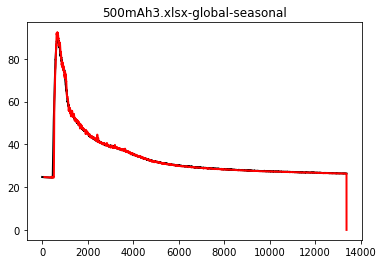

In [22]:

pltx = np.arange(0,len(ts))
plt.plot(pltx,ts,linewidth = 2, color='k')
    
plt.plot(pltx[global_sid:],global_forecast[global_sid:],linewidth =2, color = 'r')

title = test_data+'-global-seasonal'
plt.title(title)
plt.show()
